# All MBD sites, MAF filtering 0.05, RankNorm


In [2]:
INPUT = '../analyses/2bRAD/Inputs/'
mQTL = '../analyses/2bRAD/mQTL_5x/'

In [3]:
#function to run bash commands cleanly
js <- function(shell_command){
    cat(system(shell_command, intern=TRUE), sep='\n')}

## Format genetic data

In [4]:
library(MatrixEQTL)
library(tidyverse)
library(reshape2)
library(ggpubr)

Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘America/Chicago’ (or equivalent)”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




Read in previouslt generated .geno file, with data for at least 7 individuals in each population and overal MAF of 0.05.

In [5]:
geno <- read.table(paste0(INPUT,'MBD_HCSS_Afilt32m70_maf05_m2pop.geno'))

In [6]:
dim(geno)

[1] 2860   18

In [7]:
head(geno)

,HC1.2,HC1.4,HC2.15,HC2.17,HC3.1,HC3.5,HC3.7,HC3.10,HC3.11,SS2.9,SS2.14,SS2.18,SS3.3,SS3.14,SS3.15,SS3.16,SS3.20,SS5.18
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Contig0_109103,1,1,0,1,2,0,0,1,1,0,0,0,0,2,0,1,0,2
Contig0_109119,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0
Contig0_109123,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0
Contig3_14914,0,0,0,0,0,0,0,1,0,0,0,1,1,0,2,1,1,1
Contig4_51093,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Contig9_17749,1,0,0,0,0,1,0,0,0,1,1,1,0,2,1,0,0,1


In [8]:
geno <- cbind(as.character(rownames(geno)),geno)
rownames(geno) <- NULL
# change sample names to match epigenetics
mbdorder = c("hc1_2","hc1_4","hc2_15","hc2_17","hc3_1","hc3_5","hc3_7","hc3_10","hc3_11",
        "ss2_9","ss2_14","ss2_18","ss3_3","ss3_14","ss3_15","ss3_16","ss3_20","ss5_18")
colnames(geno) <- c("id",mbdorder)
head(geno)
write.table(geno,paste0(mQTL,'MBD_HCSS_Afilt32m70_maf05_m2pop_format.tab'),sep="\t",quote = F,row.names = F)

,id,hc1_2,hc1_4,hc2_15,hc2_17,hc3_1,hc3_5,hc3_7,hc3_10,hc3_11,ss2_9,ss2_14,ss2_18,ss3_3,ss3_14,ss3_15,ss3_16,ss3_20,ss5_18
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Contig0_109103,1,1,0,1,2,0,0,1,1,0,0,0,0,2,0,1,0,2
2,Contig0_109119,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Contig0_109123,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Contig3_14914,0,0,0,0,0,0,0,1,0,0,0,1,1,0,2,1,1,1
5,Contig4_51093,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,Contig9_17749,1,0,0,0,0,1,0,0,0,1,1,1,0,2,1,0,0,1


In [9]:
geno %>% mutate_if(is.factor, as.character) -> geno

In [10]:
# get snp position file
geno <- as.data.frame(geno,stringsAsFactors = F)
chr = sapply(strsplit(geno$id,"_"), '[',1)
pos = sapply(strsplit(geno$id,"_"), '[',2)
snppos <- as.data.frame(cbind(geno$id,chr,pos),stringsAsFactors = F)
snppos$pos <- as.numeric(snppos$pos)
colnames(snppos) <- c('snp','chr','pos')
head(snppos)
write.table(snppos,file=paste(mQTL,"snppos_mqtl_05_m2pop.tab"),quote = F,row.names = F,sep = "\t")

,snp,chr,pos
,<chr>,<chr>,<dbl>
1,Contig0_109103,Contig0,109103
2,Contig0_109119,Contig0,109119
3,Contig0_109123,Contig0,109123
4,Contig3_14914,Contig3,14914
5,Contig4_51093,Contig4,51093
6,Contig9_17749,Contig9,17749


In [11]:
bed <- cbind(chr,pos,pos, geno$id)
write.table(bed,file=paste0(mQTL,"snppos_mqtl_05_m2pop.BED"),quote = F,row.names = F,col.names=F,sep = "\t")

In [12]:
dim(geno)

[1] 2860   19

# Looking at individual methylated sites

## Format methylation data

In [13]:
mf <- read.table("../analyses/methylation-filtered/percent-methylation-filtered.tab",header=T)
#add sample names
colnames(mf) <- c("id",mbdorder)
head(mf)
write.table(mf,paste0(mQTL,"meth_filter_allsites.tab"),sep="\t",row.names = F,quote = F)

,id,hc1_2,hc1_4,hc2_15,hc2_17,hc3_1,hc3_5,hc3_7,hc3_10,hc3_11,ss2_9,ss2_14,ss2_18,ss3_3,ss3_14,ss3_15,ss3_16,ss3_20,ss5_18
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Contig0.38965.38965,50.00000,83.33333,45.45455,40.00000,36.36364,60.00000,66.66667,44.44444,80.00000,100.00000,66.66667,57.14286,75.00000,40.00000,28.57143,33.33333,66.66667,58.33333
2,Contig0.38973.38973,86.66667,93.75000,81.25000,76.92308,80.00000,70.58824,92.30769,81.81818,68.42105,83.33333,66.66667,73.33333,63.63636,75.00000,77.77778,80.00000,75.00000,88.23529
3,Contig0.39226.39226,52.38095,77.27273,45.45455,60.86957,37.50000,63.63636,45.00000,62.50000,58.06452,52.94118,80.00000,65.21739,61.11111,50.00000,40.00000,61.53846,42.10526,32.00000
4,Contig0.39234.39234,41.66667,25.92593,37.03704,19.23077,41.37931,42.30769,30.43478,33.33333,22.22222,36.84211,14.28571,34.48276,45.00000,41.66667,48.00000,29.41176,52.17391,33.33333
5,Contig0.39252.39252,69.23077,72.72727,54.54545,75.00000,76.92308,72.72727,80.00000,69.23077,71.42857,57.14286,50.00000,75.00000,87.50000,66.66667,66.66667,20.00000,50.00000,80.00000
6,Contig0.64179.64179,90.90909,66.66667,88.88889,95.23810,75.00000,100.00000,42.85714,91.66667,60.00000,50.00000,80.00000,75.00000,75.00000,75.00000,89.47368,100.00000,100.00000,46.66667


In [13]:
mf <- read.table(paste0(mQTL,"meth_filter_allsites.tab"),header=T)

In [48]:
dim(mf)

[1] 252366     19

In [46]:
remove = c()
for (row in 1:nrow(mf)) {
    minR <- min(mf[row,2:19],na.rm = T)
    maxR <- max(mf[row, 2:19],na.rm=T)
    if(maxR-minR < 12 ) {
        remove = c(remove,row)
    }
}


In [49]:
mf_12 <- mf %>% slice(-remove)
dim(mf_12)

[1] 232567     19

In [14]:
perc_meth <- melt(mf,variable.name = "sample",value.name = "percMeth")
perc_meth <- mutate(perc_meth,pop=substr(sample,1,2))
head(perc_meth)

Using id as id variables



,id,sample,percMeth,pop
,<chr>,<fct>,<dbl>,<chr>
1,Contig0.38965.38965,hc1_2,50.00000,hc
2,Contig0.38973.38973,hc1_2,86.66667,hc
3,Contig0.39226.39226,hc1_2,52.38095,hc
4,Contig0.39234.39234,hc1_2,41.66667,hc
5,Contig0.39252.39252,hc1_2,69.23077,hc
6,Contig0.64179.64179,hc1_2,90.90909,hc


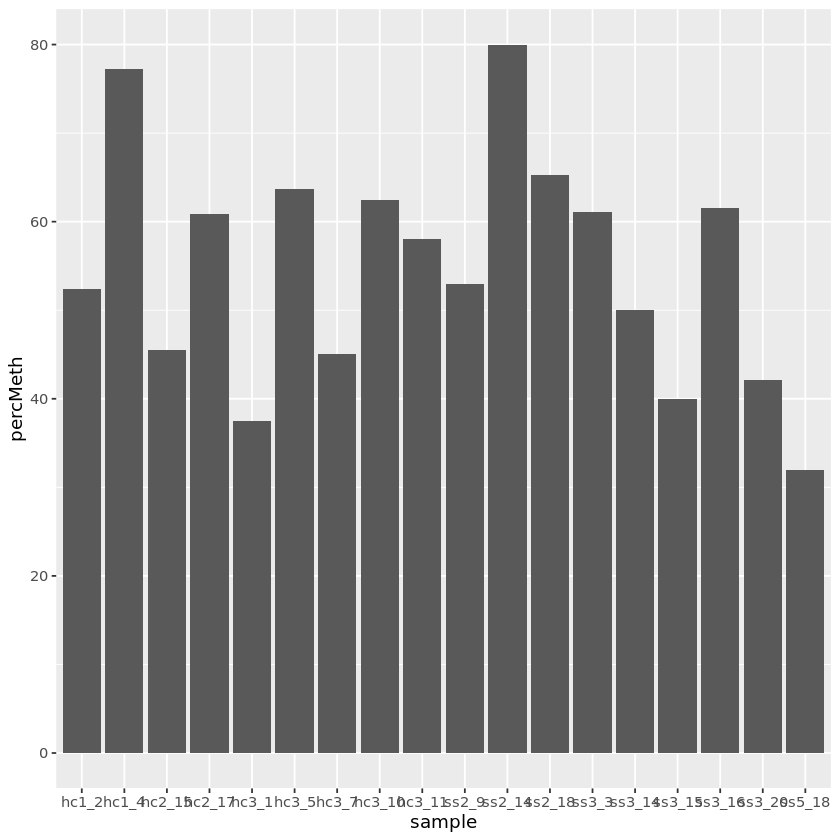

In [16]:
# check a couple loci to make sure % methylation is calculated separately for each sample and gene region 
perc_meth %>% filter(id=="Contig0.39226.39226") %>% ggplot(aes(x=sample, y=percMeth)) + geom_bar(stat="identity")

In [17]:
myRN <- function(x){
    
    y <- x[2:19][!is.na(x[2:19])]
    n <- length(y)
    k = 0.375  
  # Ranks.
      r <- rank(y)
  
  # Apply transformation.
    out <- qnorm((r - k) / (n - 2 * k + 1))
    x[2:19][!is.na(x[2:19])] <- out
    return(x)
}


In [50]:
df_list <- lapply(1:nrow(mf_12), function(r_num) { myRN(mf_12[r_num, ]) })
dcN12<- do.call(rbind, df_list)

In [52]:
write.table(dcN12,paste0(mQTL,"meth_filter_12_RankNorm.tab"),sep="\t",row.names = F,quote = F)
head(dcN12)

,id,hc1_2,hc1_4,hc2_15,hc2_17,hc3_1,hc3_5,hc3_7,hc3_10,hc3_11,ss2_9,ss2_14,ss2_18,ss3_3,ss3_14,ss3_15,ss3_16,ss3_20,ss5_18
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Contig0.38965.38965,-0.2075038,1.3466835,-0.3504148,-0.7519938,-1.0632442,0.2075038,0.5009045,-0.5009045,1.06324418,1.82174853,0.50090447,-0.06872882,0.8465244,-0.7519938,-1.82174853,-1.3466835,0.5009045,0.06872882
2,Contig0.38973.38973,0.8465244,1.8217485,0.3504148,-0.2075038,0.1377842,-0.8465244,1.3466835,0.5009045,-1.06324418,0.66375159,-1.34668349,-0.66375159,-1.8217485,-0.4244566,-0.06872882,0.1377842,-0.4244566,1.06324418
3,Contig0.39226.39226,-0.2075038,1.3466835,-0.5009045,0.2075038,-1.3466835,0.8465244,-0.6637516,0.6637516,0.06872882,-0.06872882,1.82174853,1.06324418,0.3504148,-0.3504148,-1.06324418,0.5009045,-0.8465244,-1.82174853
4,Contig0.39234.39234,0.5804016,-0.8465244,0.2075038,-1.3466835,0.3504148,0.8465244,-0.5009045,-0.2782481,-1.06324418,0.06872882,-1.82174853,-0.06872882,1.0632442,0.5804016,1.34668349,-0.6637516,1.8217485,-0.27824809
5,Contig0.39252.39252,-0.1377842,0.2782481,-0.8465244,0.5804016,0.8465244,0.2782481,1.1929813,-0.1377842,0.06872882,-0.66375159,-1.19298126,0.58040159,1.8217485,-0.4244566,-0.42445656,-1.8217485,-1.1929813,1.19298126
6,Contig0.64179.64179,0.5009045,-0.6637516,0.2075038,0.8465244,-0.2782481,1.3466835,-1.8217485,0.6637516,-0.84652439,-1.06324418,0.06872882,-0.27824809,-0.2782481,-0.2782481,0.35041483,1.3466835,1.3466835,-1.34668349


In [32]:
myRN <- function(x){
    
    y <- x[2:19][!is.na(x[2:19])]
    n <- length(y)
    k = 0.375  
  # Ranks.
      r <- rank(y)
  
  # Apply transformation.
    out <- qnorm((r - k) / (n - 2 * k + 1))
    x[2:19][!is.na(x[2:19])] <- out
    return(x)
}


In [33]:
df_list <- lapply(1:nrow(dc), function(r_num) { myRN(dc[r_num, ]) })
dcN<- do.call(rbind, df_list)

In [16]:
write.table(dcN,paste0(mQTL,"meth_filter_allsites_RankNorm.tab"),sep="\t",row.names = F,quote = F)
head(dcN)

,id,hc1_2,hc1_4,hc2_15,hc2_17,hc3_1,hc3_5,hc3_7,hc3_10,hc3_11,ss2_9,ss2_14,ss2_18,ss3_3,ss3_14,ss3_15,ss3_16,ss3_20,ss5_18
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Contig0_39226_39226,-0.1458270,1.7961934,-0.4507442,0.4507442,-1.3153098,0.8059185,-0.6185211,1.0271543,0.1458270,0.0000000,NA,1.3153098,0.2948402,-0.2948402,-1.0271543,0.6185211,-0.8059185,-1.7961934
2,Contig0_39234_39234,0.3716615,-1.0271543,0.1458270,-1.7961934,0.8059185,1.0271543,-0.6185211,-0.2948402,-1.3153098,0.0000000,NA,-0.1458270,0.6185211,0.3716615,1.3153098,-0.8059185,1.7961934,-0.4507442
3,Contig0_64179_64179,0.3348942,-0.7137046,NA,0.7137046,-0.4232249,1.2450462,-1.7393842,0.5149938,-0.9457771,NA,NA,-0.1651163,-0.4232249,0.0000000,0.1651163,1.2450462,1.2450462,-1.2450462
4,Contig0_71523_71523,0.9109555,0.9109555,0.9109555,0.0000000,-1.3153098,NA,-1.7961934,0.9109555,0.1458270,-0.8059185,0.2948402,0.9109555,-0.6185211,-0.3716615,-0.1458270,-0.3716615,-1.0271543,0.9109555
5,Contig0_71533_71533,0.5804016,0.5804016,-1.0632442,0.5804016,0.5804016,0.5804016,-1.8217485,0.5804016,0.5804016,0.5804016,0.5804016,-1.3466835,-0.2075038,-0.5804016,-0.8465244,-0.5804016,0.5804016,-0.3504148
6,Contig0_71542_71542,-0.8465244,0.5009045,0.5009045,0.5009045,0.5009045,0.5009045,0.5009045,-1.1929813,0.5009045,0.5009045,0.5009045,0.5009045,0.5009045,-0.5804016,-0.3504148,-1.8217485,-1.1929813,-0.5804016


In [53]:
# get meth position file
dcN12 <- as.data.frame(dcN12,stringsAsFactors = F)
chr = sapply(strsplit(dcN12$id,"[.]"), '[',1)
s1 = as.numeric(sapply(strsplit(dcN12$id,"[.]"), '[',2))
s2 = as.numeric(sapply(strsplit(dcN12$id,"[.]"), '[',3))
methpos <- as.data.frame(cbind(dcN12$id,chr,s1,s2),stringsAsFactors = F)
methpos$s1 <- as.numeric(methpos$s1)
methpos$s2 <- as.numeric(methpos$s2)
colnames(methpos) <- c('geneid','chr','s1','s2')
head(methpos)
write.table(methpos,file=paste0(mQTL,"methsitespos_12_mqtl.tab"),quote = F,row.names = F,sep = "\t")

,geneid,chr,s1,s2
,<chr>,<chr>,<dbl>,<dbl>
1,Contig0.38965.38965,Contig0,38965,38965
2,Contig0.38973.38973,Contig0,38973,38973
3,Contig0.39226.39226,Contig0,39226,39226
4,Contig0.39234.39234,Contig0,39234,39234
5,Contig0.39252.39252,Contig0,39252,39252
6,Contig0.64179.64179,Contig0,64179,64179


In [54]:
bed <- cbind(chr,s1,s2, dcN12$id)
write.table(bed,file=paste0(mQTL,"methsitepos_12_mqtl.BED"),quote = F,row.names = F,col.names=F,sep = "\t")

In [22]:
pca <- as.matrix(read.table("../analyses/2bRAD/PCA_MBD.tab"))
rownames(pca) <- mbdorder
head(pca)

,Axis1,Axis2,Axis3,Axis4,Axis5,Axis6,Axis7,Axis8,Axis9,Axis10
hc1_2,-30.85435,62.502919,-39.126699,-6.682553,8.322146,-0.7086301,17.317525,0.2936824,0.8989264,-0.4304196
hc1_4,-36.76328,-28.075423,-8.433215,7.664743,-1.618463,-31.0590303,-9.857334,-8.3973498,-27.8566307,-0.9438271
hc2_15,-19.18685,-5.184282,7.364130,13.135168,-4.388550,12.5090228,-22.747310,24.8400420,-65.7538216,13.3349372
hc2_17,-40.20686,-36.105270,-12.322371,9.687674,2.635277,-58.6181161,-13.758874,-23.7416069,23.5703357,-6.2352104
hc3_1,-37.82643,-36.942524,-5.509531,1.518255,-4.692239,48.6833461,23.362380,9.7129216,21.5883136,-3.5359827
hc3_5,-30.14360,55.023133,-36.232789,-5.362076,1.008838,-0.7074565,14.193249,-9.9157602,-3.6163448,3.2526797


In [23]:
# covariate
id = mbdorder
covariate <- rbind(id,t(pca[,1:3]))
write.table(covariate,paste0(mQTL,"covariate_PCA.tab"),sep="\t",row.names=T,quote=F, col.names=F)

In [31]:
js("cat ../analyses/2bRAD/mQTL/covariate_PCA.tab")

id	hc1_2	hc1_4	hc2_15	hc2_17	hc3_1	hc3_5	hc3_7	hc3_10	hc3_11	ss2_9	ss2_14	ss2_18	ss3_3	ss3_14	ss3_15	ss3_16	ss3_20	ss5_18
Axis1	-30.8543488156875	-36.7632815520323	-19.1868459086878	-40.2068600553614	-37.8264309307188	-30.1435952942239	-43.147805064287	-17.1723893577857	-19.2105366809675	32.1947376175343	32.1172093930606	37.9439432633294	46.4649184865142	38.2455275871164	4.05428367372196	32.3602240933444	5.85256860489092	45.2786809402398
Axis2	62.5029187081274	-28.0754231683899	-5.18428177862099	-36.1052703640299	-36.9425235689188	55.0231331543907	-40.1710197533959	33.7748409144085	6.78545360109611	-0.74738750177114	-0.40058296272575	-7.4312127359522	-5.83359739260907	-7.36625377184771	26.7017972049959	-4.00565592110267	-1.10587050768295	-11.419064155972
Axis3	-39.1266989566545	-8.43321512801454	7.36412985077157	-12.3223707969935	-5.5095307711699	-36.2327888745743	-7.61175942057101	24.5313250984492	48.3586753838834	-7.02619515527421	-3.77094356512209	-9.53265297227056	-16.2836332825772

In [55]:
js("bedtools window -w 50000 -u -a ../analyses/2bRAD/mQTL_5x/snppos_mqtl_05_m2pop.BED -b ../analyses/2bRAD/mQTL_5x/methsitepos_12_mqtl.BED > ../analyses/2bRAD/mQTL_5x/snpAmeth12B_50kb.txt")

In [56]:
js("bedtools window -w 50000 -u -b ../analyses/2bRAD/mQTL_5x/snppos_mqtl_05_m2pop.BED -a ../analyses/2bRAD/mQTL_5x/methsitepos_12_mqtl.BED > ../analyses/2bRAD/mQTL_5x/snpBmeth12A_50kb.txt")

In [57]:
# how many SNPs are within 50kb of a methylated site
js("wc -l ../analyses/2bRAD/mQTL_5x/snpAmeth12B_50kb.txt")

853 ../analyses/2bRAD/mQTL_5x/snpAmeth12B_50kb.txt


In [58]:
#how many mbd sites within 50kb of a SNP
js("wc -l ../analyses/2bRAD/mQTL_5x/snpBmeth12A_50kb.txt")

10320 ../analyses/2bRAD/mQTL_5x/snpBmeth12A_50kb.txt


In [59]:
js("head ../analyses/2bRAD/mQTL_5x/snpBmeth12A_50kb.txt")

Contig0	64179	64179	Contig0.64179.64179
Contig0	64210	64210	Contig0.64210.64210
Contig0	64217	64217	Contig0.64217.64217
Contig0	64238	64238	Contig0.64238.64238
Contig0	64253	64253	Contig0.64253.64253
Contig0	64276	64276	Contig0.64276.64276
Contig0	64285	64285	Contig0.64285.64285
Contig0	64288	64288	Contig0.64288.64288
Contig0	64309	64309	Contig0.64309.64309
Contig0	64353	64353	Contig0.64353.64353


## Run eQTL

In [60]:
# set parameters
useModel = modelLINEAR
snpfile = paste0(mQTL,"MBD_HCSS_Afilt32m70_maf05_m2pop_format.tab")
methfile = paste0(mQTL,"meth_filter_12_RankNorm.tab")
covfile = paste0(mQTL,"covariate_PCA.tab")

snposfile = paste0(mQTL,"snppos_mqtl_05_m2pop.tab")

pvOutputThresholdcis = 0.01
pvOutputThresholdtrans = 0.01
output_file_name_cis = paste0(mQTL,"mQTL_sites_cis50kb_12_p01_maf05.txt")
output_file_name_tra = paste0(mQTL,"mQTL_sites_trans50kb_12_p01_maf05.txt")
#errorCovariance = rab2;
errorCovariance = numeric()
# Distance for local gene-SNP pairs
cisDist = 50000  #50kb

In [25]:
snps = SlicedData$new();
snps$fileDelimiter = "\t";      # the TAB character
snps$fileOmitCharacters = "NA"; # denote missing values;
snps$fileSkipRows = 1;          # one row of column labels
snps$fileSkipColumns = 1;       # one column of row labels
snps$fileSliceSize = 2000;      # read file in pieces of 2,000 rows
snps$LoadFile( snpfile )

Rows read: 2,000

Rows read: 2860 done.



In [61]:
meth = SlicedData$new();
meth$fileDelimiter = "\t";      # the TAB character
meth$fileOmitCharacters = "NA"; # denote missing values;
meth$fileSkipRows = 1;          # one row of column labels
meth$fileSkipColumns = 1;       # one column of row labels
meth$fileSliceSize = 2000;      # read file in pieces of 2,000 rows
meth$LoadFile( methfile )

Rows read: 2,000

Rows read: 4,000

Rows read: 6,000

Rows read: 8,000

Rows read: 10,000

Rows read: 12,000

Rows read: 14,000

Rows read: 16,000

Rows read: 18,000

Rows read: 20,000

Rows read: 22,000

Rows read: 24,000

Rows read: 26,000

Rows read: 28,000

Rows read: 30,000

Rows read: 32,000

Rows read: 34,000

Rows read: 36,000

Rows read: 38,000

Rows read: 40,000

Rows read: 42,000

Rows read: 44,000

Rows read: 46,000

Rows read: 48,000

Rows read: 50,000

Rows read: 52,000

Rows read: 54,000

Rows read: 56,000

Rows read: 58,000

Rows read: 60,000

Rows read: 62,000

Rows read: 64,000

Rows read: 66,000

Rows read: 68,000

Rows read: 70,000

Rows read: 72,000

Rows read: 74,000

Rows read: 76,000

Rows read: 78,000

Rows read: 80,000

Rows read: 82,000

Rows read: 84,000

Rows read: 86,000

Rows read: 88,000

Rows read: 90,000

Rows read: 92,000

Rows read: 94,000

Rows read: 96,000

Rows read: 98,000

Rows read: 100,000

Rows read: 102,000

Rows read: 104,000

Rows read: 10

In [27]:
cvrt = SlicedData$new();
cvrt$fileDelimiter = "\t";      # the TAB character
cvrt$fileOmitCharacters = "NA"; # denote missing values;
cvrt$fileSkipRows = 1;          # one row of column labels
cvrt$fileSkipColumns = 1;       # one column of row labels
cvrt$fileSliceSize = 2000;      # read file in pieces of 2,000 rows
cvrt$LoadFile( covfile )

Rows read: 3 done.



In [16]:
meS$cis$neqtls
meS$cis$ntests

[1] 277

[1] 13940

In [62]:
## Run the analysis

meS = Matrix_eQTL_main(
snps = snps, 
gene = meth, 
cvrt = cvrt,
output_file_name     = output_file_name_tra,
pvOutputThreshold     = pvOutputThresholdtrans,
useModel = useModel, 
errorCovariance = errorCovariance, 
verbose = TRUE, 
output_file_name.cis = output_file_name_cis,
pvOutputThreshold.cis = pvOutputThresholdcis,
snpspos = snppos, 
genepos = methpos,
cisDist = cisDist,
pvalue.hist = "qqplot",
min.pv.by.genesnp = TRUE,
noFDRsaveMemory = FALSE);

unlink(output_file_name_tra);
unlink(output_file_name_cis);

Matching data files and location files

232567 of 232567 genes matched

2860 of 2860 SNPs matched


Task finished in 0.072 seconds

Reordering genes

Task finished in 3.115 seconds

Processing covariates

Task finished in 0.004 seconds

Processing gene expression data (imputation, residualization)

Task finished in 0.255 seconds

Creating output file(s)

Warning message in Matrix_eQTL_main(snps = snps, gene = meth, cvrt = cvrt, output_file_name = output_file_name_tra, :
“Warning: pvOutputThreshold may be too large.
Expected number of findings > 6651416.2”
Task finished in 0.058 seconds

Performing eQTL analysis

 0.42% done, 40 cis-eQTLs, 41,907 trans-eQTLs

 0.85% done, 97 cis-eQTLs, 83,312 trans-eQTLs

 1.28% done, 157 cis-eQTLs, 124,840 trans-eQTLs

 1.70% done, 202 cis-eQTLs, 165,748 trans-eQTLs

 2.13% done, 248 cis-eQTLs, 207,193 trans-eQTLs

 2.56% done, 249,598 trans-eQTLs

 2.99% done, 291,107 trans-eQTLs

 3.41% done, 332,328 trans-eQTLs

 3.84% done, 374,717 trans-eQTLs

 4.

In [66]:
meS$trans$neqtls
meS$trans$ntests

[1] 6943226

[1] 665127680

In [63]:
save(meS,file=paste0(mQTL,"MBD_HCSS_Afilt32m70_maf05_m2pop_sites50k_mQTL_12_RNPCA"))

In [15]:
load(file=paste0(mQTL,"MBD_HCSS_Afilt32m70_maf05_m2pop_sites50k_mQTL_12_RNPCA"))

In [73]:
cat('Detected local eQTLs:', '\n');
head(meS$cis$eqtls, n=20)

Detected local eQTLs: 


,snps,gene,statistic,pvalue,FDR,beta
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Contig346666_6197,Contig346666.5591.5591,7.892763,2.591407e-06,0.01805409,0.8505726
2,Contig20924_31357,Contig20924.31674.31674,-7.643323,3.671072e-06,0.01805409,-1.1106514
3,Contig51028_11639,Contig51028.20112.20112,-7.603193,3.885386e-06,0.01805409,-1.9808249
4,Contig29931_24809,Contig29931.8179.8179,6.772391,1.316631e-05,0.04588459,0.9477876
5,Contig35529_2509,Contig35529.2508.2508,-5.402653,1.205927e-04,0.24586321,-1.6268296
6,Contig36473_28460,Contig36473.30294.30294,5.391383,1.229432e-04,0.24586321,1.3659333
7,Contig470690_766,Contig470690.1320.1320,-5.384956,1.243052e-04,0.24586321,-1.9036519
8,Contig24692_9048,Contig24692.5776.5776,-5.243914,1.585264e-04,0.24586321,-1.6943657
9,Contig21828_42443,Contig21828.45513.45513,5.207308,1.689295e-04,0.24586321,0.8485381


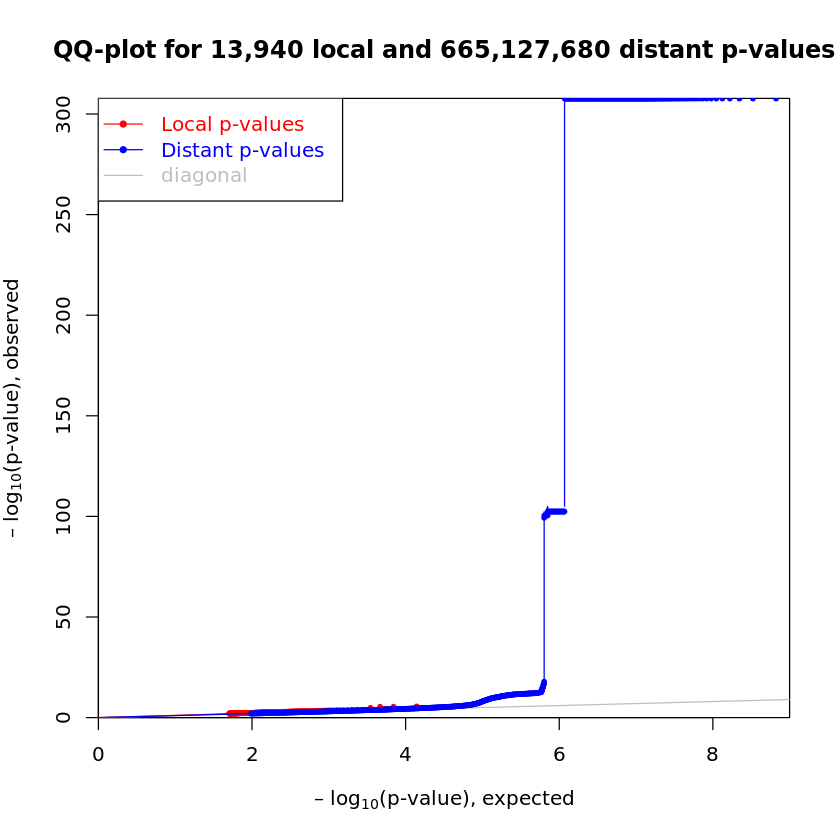

In [68]:
plot(meS)

### looking at trans genes that are highly sih

In [6]:
meS$trans$neqtls

[1] 1011397

In [83]:
trans_snps <- sigtrans %>%
group_by(snps) %>%
dplyr::summarise(
    mean_pval= mean(pvalue, na.rm=TRUE),
    mean_beta= mean(beta,na.rm=TRUE),
    n()) 
 
dim(trans_snps)

[1] 1758    4

In [84]:
mean(trans_snps$`n()`)

[1] 6.171786

In [75]:
sigtrans <- meS$trans$eqtls[which(meS$trans$eqtls$FDR < 0.05),]
# Calculate mean p-value for each sig trans meth site
mean_sigtrans <- sigtrans %>% 
   group_by(gene) %>%
   dplyr::summarise(
    mean_fdr= mean(FDR, na.rm=TRUE),
    mean_beta= mean(beta,na.rm=TRUE),
    n())  
dim(mean_sigtrans)

[1] 5251    4

In [76]:
dim(sigtrans)

[1] 10850     6

In [77]:
mean(mean_sigtrans$`n()`)

[1] 2.066273

* 5251 methylated sites out of 232,567 total sites have at least 1 trans (> 50kb away) SNP that is statistically linked (FDR < 5%). Mean 2.07 SNPs are significantly associated with each site. 1758 SNPs are associated with at least 1 site, mean 6.17 sites per SNP. (RN, PCA1-3) 

In [78]:
head(mean_sigtrans[order(mean_sigtrans$mean_beta,decreasing = T),],n = 20)

gene,mean_fdr,mean_beta,n()
<chr>,<dbl>,<dbl>,<int>
Contig102110.9040.9040,0.007949475,2.957405,4
Contig84548.13612.13612,0.048040949,2.762224,4
Contig102342.2823.2823,0.008765878,2.656596,5
Contig125668.1515.1515,0.008765878,2.656596,5
Contig125668.1715.1715,0.008765878,2.656596,5
Contig17712.3409.3409,0.008765878,2.656596,5
Contig29738.10725.10725,0.008765878,2.656596,5
Contig33119.13571.13571,0.008765878,2.656596,5
Contig72069.4733.4733,0.008765878,2.656596,5


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



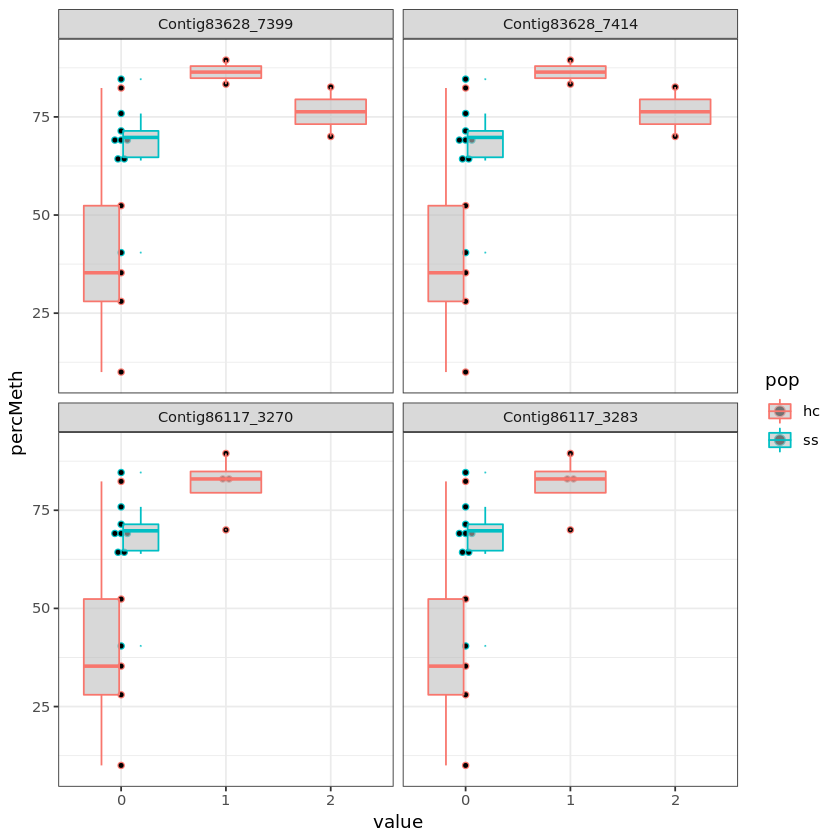

In [81]:
m <- perc_meth %>% filter(id=="Contig102110.9040.9040")
s <- meS$trans$eqtls[which(meS$trans$eqtls$gene == "Contig102110.9040.9040" & meS$trans$eqtls$FDR < 0.05),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",5:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=pop)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw()

### Cis snps

In [82]:
meS$cis$neqtls

[1] 277

In [85]:
# Calculate mean p-value for each sig trans meth site
mean_sigcis <- meS$cis$eqtls %>% 
   group_by(gene) %>%
   dplyr::summarise(
    mean_pval= mean(pvalue, na.rm=TRUE),
    mean_beta= mean(beta,na.rm=TRUE),
    n())  
dim(mean_sigcis)

[1] 240   4

In [109]:
# get sig meth sites
sig_meth_cis <- as.character(unique(meS$cis$eqtls$gene))

In [110]:
length(sig_meth_cis)

[1] 240

In [111]:
chr <- sapply(strsplit(sig_meth_cis,"[.]"), `[`, 1)
start <- sapply(strsplit(sig_meth_cis,"[.]"), `[`, 2)
end <- start
bed <- cbind(chr,start,end)
write.table(bed,"../analyses/2bRAD/mQTL_5x/meth_mbd_maf05_sites_cis.bed",row.names = F, col.names = F,quote = F, sep = "\t")

In [82]:
meS$cis$neqtls

[1] 277

In [41]:
# Calculate mean p-value for each sig trans meth site
mean_sigcis <- meS$cis$eqtls %>% 
   group_by(gene) %>%
   dplyr::summarise(
    mean_pval= mean(pvalue, na.rm=TRUE),
    mean_beta= mean(beta,na.rm=TRUE),
    n())  
dim(mean_sigcis)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 121   4

In [86]:
mean(mean_sigcis$`n()`)

[1] 1.154167

In [87]:
cis_snps <- meS$cis$eqtls %>%
group_by(snps) %>%
dplyr::summarise(
    mean_pval= mean(pvalue, na.rm=TRUE),
    mean_beta= mean(beta,na.rm=TRUE),
    n()) 
 
dim(cis_snps)

[1] 176   4

In [88]:
mean(cis_snps$`n()`)

[1] 1.573864

240 methylated sites out of X total sites have at least 1 cis (< 50kb away) SNP that is statistically linked (pvalue < 0.01). Mean 1.15 SNPs are significantly associated with each bin. 176 SNPs are associated with at least 1 site, mean 1.57 sites per SNP.  

In [92]:
head(meS$cis$eqtls,n=20)

,snps,gene,statistic,pvalue,FDR,beta
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Contig346666_6197,Contig346666.5591.5591,7.892763,2.591407e-06,0.01805409,0.8505726
2,Contig20924_31357,Contig20924.31674.31674,-7.643323,3.671072e-06,0.01805409,-1.1106514
3,Contig51028_11639,Contig51028.20112.20112,-7.603193,3.885386e-06,0.01805409,-1.9808249
4,Contig29931_24809,Contig29931.8179.8179,6.772391,1.316631e-05,0.04588459,0.9477876
5,Contig35529_2509,Contig35529.2508.2508,-5.402653,1.205927e-04,0.24586321,-1.6268296
6,Contig36473_28460,Contig36473.30294.30294,5.391383,1.229432e-04,0.24586321,1.3659333
7,Contig470690_766,Contig470690.1320.1320,-5.384956,1.243052e-04,0.24586321,-1.9036519
8,Contig24692_9048,Contig24692.5776.5776,-5.243914,1.585264e-04,0.24586321,-1.6943657
9,Contig21828_42443,Contig21828.45513.45513,5.207308,1.689295e-04,0.24586321,0.8485381


In [90]:
write.table(meS$cis$eqtls,paste0(mQTL,"mQTL_12_sites_cis50kb_p01_maf05_2pop_RNPCA.txt"),quote = F,row.names = F)

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



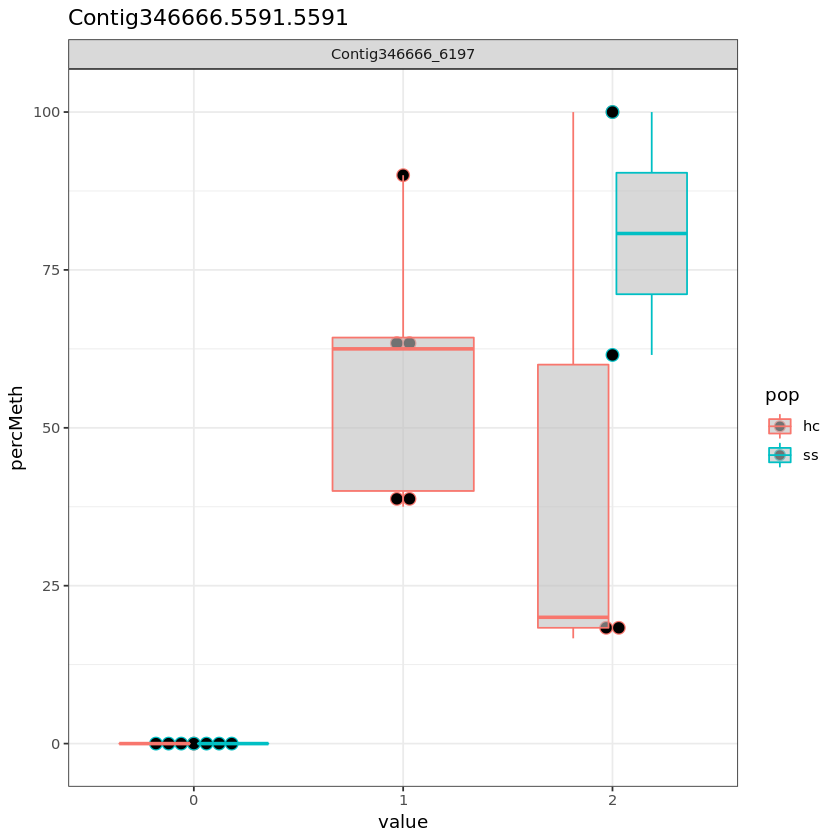

In [93]:
m <- perc_meth %>% filter(id=="Contig346666.5591.5591")
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == "Contig346666.5591.5591"),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",5:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=pop)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle("Contig346666.5591.5591")

### All cis-meQTLs

In [94]:
for(gene in unique(meS$cis$eqtls$gene)){
    m <- perc_meth %>% filter(id==gene)
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == gene),]$snps
    pval <- signif(mean_sigcis[which(mean_sigcis$gene == gene),"mean_pval"],digits=3)

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
    
mer <- merge(m,g) %>% tidyr::gather("id","value",5:ncol(merge(m,g)))
mer$value <- as.numeric(mer$value)

plot <- mer %>%
ggboxplot(., x = "value", y= "percMeth",color="pop", facet.by = c("id") , add ="dotplot") + 
    ggtitle(paste(gene,pval,sep=" "))
#stat_compare_means( method = "t.test",label="p.format") + ggtitle(gene)
print(plot)
}

ERROR: Error in ggboxplot(., x = "value", y = "percMeth", color = "pop", facet.by = c("id"), : could not find function "ggboxplot"


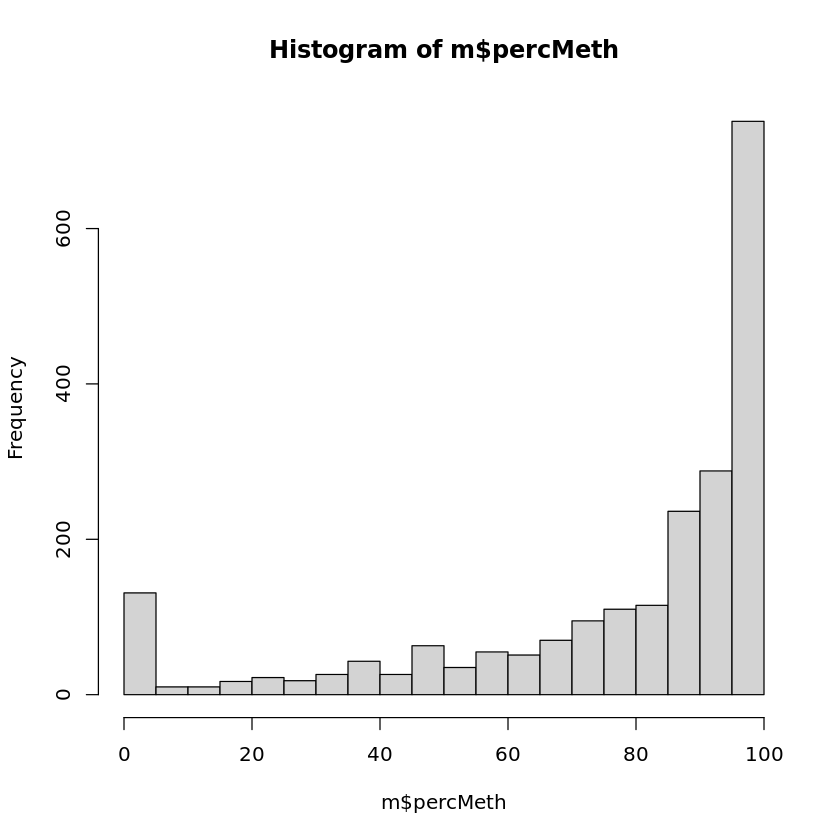

In [96]:
m <- perc_meth %>% filter(id %in% meS$cis$eqtls$gene & pop %in% "hc")
hist(m$percMeth,breaks = 20)

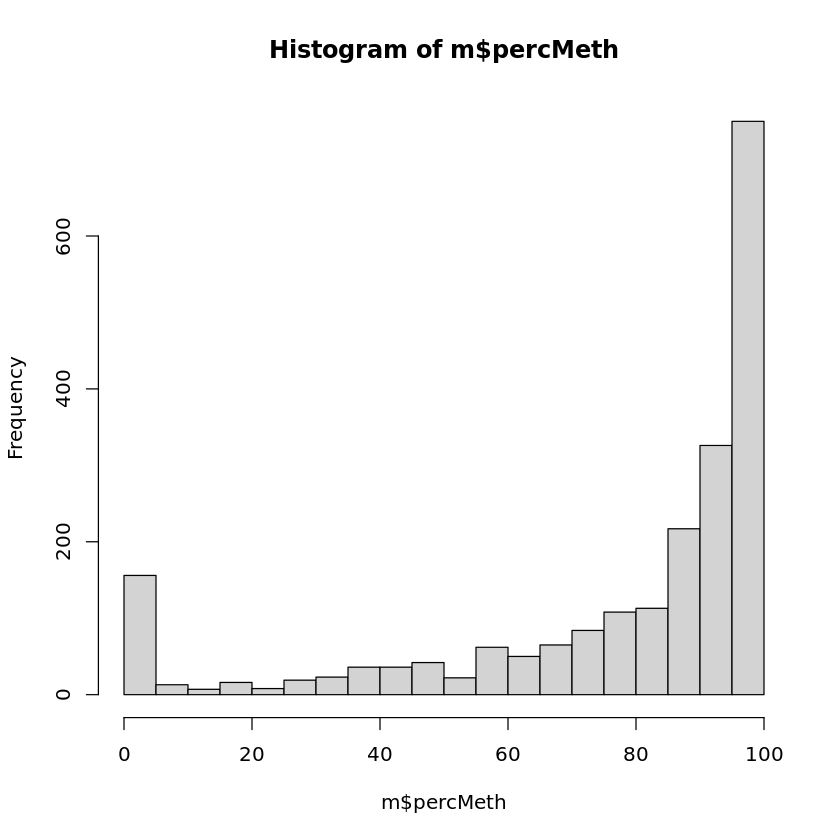

In [97]:
m <- perc_meth %>% filter(id %in% meS$cis$eqtls$gene & pop %in% "ss")
hist(m$percMeth,breaks = 20)

# No updated yet

### are there more cis mqtl than trans mqtl 

In [2]:
ncis_snpT = 349 
ncis_snp = 96 
ntran_snpT = 2860 
ntran_snp = 501

In [3]:
mat <- matrix(c(ncis_snp,ntran_snp,ncis_snpT-ncis_snp,ntran_snpT-ntran_snp),ncol=2)
dimnames(mat) <- list(c("cis","trans"),c("mQTL","non-mQTL"))
mat

,mQTL,non-mQTL
cis,96,253
trans,501,2359


In [4]:
test <- chisq.test(mat)
test


	Pearson's Chi-squared test with Yates' continuity correction

data:  mat
X-squared = 19.844, df = 1, p-value = 8.403e-06


## Enrichment - have updated

#### Make background and cis beds

Make bed file of all snps and all meth sites

#### meth background: methsitepos_12_mqtl.BED

In [99]:
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/methsitepos_12_mqtl.BED -b ../genome-features/Olurida_v081-20190709.gene.gff >  ../analyses/2bRAD/mQTL_5x/meth-background-gene.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/methsitepos_12_mqtl.BED -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff >  ../analyses/2bRAD/mQTL_5x/meth-background-gene2kb.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/methsitepos_12_mqtl.BED -b ../genome-features/Olurida_v081-20190709.2kbflank-up.gff >  ../analyses/2bRAD/mQTL_5x/meth-background-2kbflank-up.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/methsitepos_12_mqtl.BED -b ../genome-features/Olurida_v081-20190709.2kbflank-down.gff >  ../analyses/2bRAD/mQTL_5x/meth-background-2kbflank-down.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/methsitepos_12_mqtl.BED -b ../genome-features/Olurida_v081-20190709.exon.gff >  ../analyses/2bRAD/mQTL_5x/meth-background-exon.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/methsitepos_12_mqtl.BED -b ../genome-features/Olurida_v081-20190709.CDS.gff >  ../analyses/2bRAD/mQTL_5x/meth-background-CDS.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/methsitepos_12_mqtl.BED -b ../genome-features/Olurida_v081-20190709.mRNA.gff >  ../analyses/2bRAD/mQTL_5x/meth-background-mRNA.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/methsitepos_12_mqtl.BED -b ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL_5x/meth-background-TE.bed")
js("bedtools intersect -v -a ../analyses/2bRAD/mQTL_5x/methsitepos_12_mqtl.BED -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff ../genome-features/Olurida_v081-20190709.exon.gff ../genome-features/Olurida_v081-20190709.CDS.gff ../genome-features/Olurida_v081-20190709.mRNA.gff ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL_5x/meth-background-unknown.bed")

In [100]:

cisfiles <- c("../analyses/2bRAD/mQTL_5x/meth-background-CDS.bed", "../analyses/2bRAD/mQTL_5x/meth-background-exon.bed", "../analyses/2bRAD/mQTL_5x/meth-background-gene.bed", "../analyses/2bRAD/mQTL_5x/meth-background-gene2kb.bed", "../analyses/2bRAD/mQTL_5x/meth-background-2kbflank-up.bed", "../analyses/2bRAD/mQTL_5x/meth-background-2kbflank-down.bed", "../analyses/2bRAD/mQTL_5x/meth-background-mRNA.bed", "../analyses/2bRAD/mQTL_5x/meth-background-TE.bed", "../analyses/2bRAD/mQTL_5x/meth-background-unknown.bed")
cis.features <- list()
for (i in c(1:9)) {
  cis.features[[i]] <- read_delim(cisfiles[i], delim = '\t', col_names = FALSE) %>% as_tibble()}
for (i in 1:8) {
  cis.features[[i]] <- cis.features[[i]] %>%
    setNames(c("contig.cis","start.cis","end.cis","id","contig.feat", "source.feat","feature","start.feat","end.feat","unknown1","strand","unknown2","attribute")) %>%
mutate(ID=str_extract(attribute, "ID=(.*?);"),
       Parent=str_extract(attribute, "Parent=(.*?);"),
       Name=str_extract(attribute, "Name=(.*?);"),
       Alias=str_extract(attribute, "Alias=(.*?);"),
       AED=str_extract(attribute, "AED=(.*?);"),
       eAED=str_extract(attribute, "eAED=(.*?);"),
       Note=str_extract(attribute, "Note=(.*?);"),
       Ontology_term=str_extract(attribute, "Ontology_term=(.*?);"),
       Dbxref=str_extract(attribute, "Dbxref=(.*?);"),
       uniprotID=str_extract(attribute, "SPID=(.*?);")
       ) %>%
mutate_at("feature", as.factor)
}
names(cis.features) <- c("cis.CDS", "cis.exon", "cis.gene","cis.gene2kb", "cis.flank-up", "cis.flank-down","cis.mRNA", "cis.TE", "cis.unknown")
cis.features[["cis.unknown"]] <- 
  cis.features[["cis.unknown"]] %>% 
  setNames(c("contig.cis", "start.cis", "end.cis", "score.cis"))
cis.features[["cis.CDS"]] <- cis.features[["cis.CDS"]] %>% mutate_at("unknown2", as.character)
cis.features[["cis.TE"]] <- cis.features[["cis.TE"]] %>% mutate_at("unknown1", as.character)
cis.features[["cis.gene2kb"]]$feature <- "gene2kb"
cis.features[["cis.flank-up"]]$feature <- "flank-up"
cis.features[["cis.flank-down"]]$feature <- "flank-down"
cis.features[["cis.unknown"]]$feature <- "unknown"
cis.features.df <- bind_rows(cis.features) 
#save cis loci feature df object to file, to use in notebook #12 
save(cis.features.df, file="../analyses/2bRAD/mQTL_5x/meth-background.features.df")

Rows: 85729 Columns: 13

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): X1, X4, X5, X6, X7, X10, X11, X13
dbl (5): X2, X3, X8, X9, X12


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 90174 Columns: 13

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): X1, X4, X5, X6, X7, X10, X11, X12, X13
dbl (4): X2, X3, X8, X9


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 118561 Columns: 13

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): X1, X4, X5, X6, X7, X10, X11, X12, X13
dbl (4): X2, X3, X8, X9


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or

In [101]:
cis.summary <- table(cis.features.df[c("feature")]) #Note: "similarity" refers to transposable elements; also NO alternative splice variants are included. 
print(cis.summary)
save(cis.summary, file="../analyses/2bRAD/mQTL_5x/meth-background_feature.summary")
print(round(table(cis.features.df[c("feature")])/232567,2))


       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
     85729      90174       9230       9244     118561     137004     118561 
similarity    unknown 
     13231      97427 

       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      0.37       0.39       0.04       0.04       0.51       0.59       0.51 
similarity    unknown 
      0.06       0.42 


In [102]:
cis.features[["cis.gene2kb"]] %>%
   mutate(uniprotID=str_remove(uniprotID, "SPID=")) %>% mutate(uniprotID=str_remove(uniprotID, ";")) %>%
  select(uniprotID) %>% na.omit() %>% as.vector() %>% unique() %>% write.table(file="../analyses/2bRAD/mQTL_5x/background_meth_genes2kb_uniprot.txt",quote = F,row.names = F,col.names = F)

In [105]:
# how many background meth sites in genes
js("cat ../analyses/2bRAD/mQTL_5x/meth-background-gene.bed | cut  -f1,2 | sort | uniq | wc -l")

114461


In [106]:
js("head ../analyses/2bRAD/mQTL_5x/meth-background-gene.bed")

Contig0	38965	38965	Contig0.38965.38965	Contig0	maker	gene	12497	93068	.	+	.	ID=OLUR_00000039;Name=OLUR_00000039;Alias=maker-Contig0-snap-gene-0.8;Note=Similar to WDR87: WD repeat-containing protein 87 (Homo sapiens OX%3D9606);Dbxref=Coils:Coil,Gene3D:G3DSA:1.25.10.10,Gene3D:G3DSA:2.130.10.10,InterPro:IPR001680,InterPro:IPR011989,InterPro:IPR015943,InterPro:IPR016024,InterPro:IPR017986,InterPro:IPR036322,MobiDBLite:mobidb-lite,Pfam:PF00400,ProSiteProfiles:PS50082,ProSiteProfiles:PS50294,SMART:SM00320,SUPERFAMILY:SSF48371,SUPERFAMILY:SSF50978;Ontology_term=GO:0005515;SPID=Q6ZQQ6;
Contig0	38973	38973	Contig0.38973.38973	Contig0	maker	gene	12497	93068	.	+	.	ID=OLUR_00000039;Name=OLUR_00000039;Alias=maker-Contig0-snap-gene-0.8;Note=Similar to WDR87: WD repeat-containing protein 87 (Homo sapiens OX%3D9606);Dbxref=Coils:Coil,Gene3D:G3DSA:1.25.10.10,Gene3D:G3DSA:2.130.10.10,InterPro:IPR001680,InterPro:IPR011989,InterPro:IPR015943,InterPro:IPR016024,InterPro:IPR017986,InterPro:IPR036322,MobiDB

In [108]:
# how many genes with background meth sites
js("cat ../analyses/2bRAD/mQTL_5x/meth-background-gene.bed | cut  -f5,8,9 | sort | uniq | wc -l")

8046


### Identify cis meth sites in each feature with Bedtools

#### SNP background

In [112]:
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snppos_mqtl_05_m2pop.BED -b ../genome-features/Olurida_v081-20190709.gene.gff >  ../analyses/2bRAD/mQTL_5x/snp-background-gene.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snppos_mqtl_05_m2pop.BED -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff >  ../analyses/2bRAD/mQTL_5x/snp-background-gene2kb.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snppos_mqtl_05_m2pop.BED -b ../genome-features/Olurida_v081-20190709.2kbflank-up.gff >  ../analyses/2bRAD/mQTL_5x/snp-background-2kbflank-up.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snppos_mqtl_05_m2pop.BED -b ../genome-features/Olurida_v081-20190709.2kbflank-down.gff >  ../analyses/2bRAD/mQTL_5x/snp-background-2kbflank-down.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snppos_mqtl_05_m2pop.BED -b ../genome-features/Olurida_v081-20190709.exon.gff >  ../analyses/2bRAD/mQTL_5x/snp-background-exon.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snppos_mqtl_05_m2pop.BED -b ../genome-features/Olurida_v081-20190709.CDS.gff >  ../analyses/2bRAD/mQTL_5x/snp-background-CDS.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snppos_mqtl_05_m2pop.BED -b ../genome-features/Olurida_v081-20190709.mRNA.gff >  ../analyses/2bRAD/mQTL_5x/snp-background-mRNA.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snppos_mqtl_05_m2pop.BED -b ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL_5x/snp-background-TE.bed")
js("bedtools intersect -v -a ../analyses/2bRAD/mQTL_5x/snppos_mqtl_05_m2pop.BED -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff ../genome-features/Olurida_v081-20190709.exon.gff ../genome-features/Olurida_v081-20190709.CDS.gff ../genome-features/Olurida_v081-20190709.mRNA.gff ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL_5x/snp-background-unknown.bed")

In [113]:

cisfiles <- c("../analyses/2bRAD/mQTL_5x/snp-background-CDS.bed", "../analyses/2bRAD/mQTL_5x/snp-background-exon.bed", "../analyses/2bRAD/mQTL_5x/snp-background-gene.bed", "../analyses/2bRAD/mQTL_5x/snp-background-gene2kb.bed", "../analyses/2bRAD/mQTL_5x/snp-background-2kbflank-up.bed", "../analyses/2bRAD/mQTL_5x/snp-background-2kbflank-down.bed", "../analyses/2bRAD/mQTL_5x/snp-background-mRNA.bed", "../analyses/2bRAD/mQTL_5x/snp-background-TE.bed", "../analyses/2bRAD/mQTL_5x/snp-background-unknown.bed")
cis.features <- list()
for (i in c(1:9)) {
  cis.features[[i]] <- read_delim(cisfiles[i], delim = '\t', col_names = FALSE) %>% as_tibble()}
for (i in 1:8) {
  cis.features[[i]] <- cis.features[[i]] %>%
    setNames(c("contig.cis","start.cis","end.cis","id.feat","contig.feat", "source.feat","feature","start.feat","end.feat","unknown1","strand","unknown2","attribute")) %>%
mutate(ID=str_extract(attribute, "ID=(.*?);"),
       Parent=str_extract(attribute, "Parent=(.*?);"),
       Name=str_extract(attribute, "Name=(.*?);"),
       Alias=str_extract(attribute, "Alias=(.*?);"),
       AED=str_extract(attribute, "AED=(.*?);"),
       eAED=str_extract(attribute, "eAED=(.*?);"),
       Note=str_extract(attribute, "Note=(.*?);"),
       Ontology_term=str_extract(attribute, "Ontology_term=(.*?);"),
       Dbxref=str_extract(attribute, "Dbxref=(.*?);"),
       uniprotID=str_extract(attribute, "SPID=(.*?);")
       ) %>%
mutate_at("feature", as.factor)
}
names(cis.features) <- c("cis.CDS", "cis.exon", "cis.gene","cis.gene2kb", "cis.flank-up", "cis.flank-down","cis.mRNA", "cis.TE", "cis.unknown")
cis.features[["cis.unknown"]] <- 
  cis.features[["cis.unknown"]] %>% 
  setNames(c("contig.cis", "start.cis", "end.cis", "score.cis"))
cis.features[["cis.CDS"]] <- cis.features[["cis.CDS"]] %>% mutate_at("unknown2", as.character)
cis.features[["cis.TE"]] <- cis.features[["cis.TE"]] %>% mutate_at("unknown1", as.character)
cis.features[["cis.gene2kb"]]$feature <- "gene2kb"
cis.features[["cis.flank-up"]]$feature <- "flank-up"
cis.features[["cis.flank-down"]]$feature <- "flank-down"
cis.features[["cis.unknown"]]$feature <- "unknown"
cis.features.df <- bind_rows(cis.features) 
#save cis loci feature df object to file, to use in notebook #12 
save(cis.features.df, file="../analyses/2bRAD/mQTL_5x/snp-background.features.df")

Rows: 171 Columns: 13

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): X1, X4, X5, X6, X7, X10, X11, X13
dbl (5): X2, X3, X8, X9, X12


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 202 Columns: 13

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): X1, X4, X5, X6, X7, X10, X11, X12, X13
dbl (4): X2, X3, X8, X9


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 785 Columns: 13

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): X1, X4, X5, X6, X7, X10, X11, X12, X13
dbl (4): X2, X3, X8, X9


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `s

In [114]:
cis.summary <- table(cis.features.df[c("feature")]) #Note: "similarity" refers to transposable elements; also NO alternative splice variants are included. 
print(cis.summary)
save(cis.summary, file="../analyses/2bRAD/mQTL_5x/snp-background_feature.summary")
print(round(table(cis.features.df[c("feature")])/2860,2))


       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
       171        202        126        135        785       1046        785 
similarity    unknown 
       259       1720 

       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      0.06       0.07       0.04       0.05       0.27       0.37       0.27 
similarity    unknown 
      0.09       0.60 


In [115]:
cis.features[["cis.gene2kb"]] %>%
   mutate(uniprotID=str_remove(uniprotID, "SPID=")) %>% mutate(uniprotID=str_remove(uniprotID, ";")) %>%
  select(uniprotID) %>% na.omit() %>% as.vector() %>% unique() %>% write.table(file="../analyses/2bRAD/mQTL_5x/background_snp_genes2kb_uniprot.txt",quote = F,row.names = F,col.names = F)

## Cis meth sites

In [116]:
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/meth_mbd_maf05_sites_cis.bed -b ../genome-features/Olurida_v081-20190709.gene.gff >  ../analyses/2bRAD/mQTL_5x/cis-meth-gene.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/meth_mbd_maf05_sites_cis.bed -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff >  ../analyses/2bRAD/mQTL_5x/cis-meth-gene2kb.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/meth_mbd_maf05_sites_cis.bed -b ../genome-features/Olurida_v081-20190709.2kbflank-up.gff >  ../analyses/2bRAD/mQTL_5x/cis-meth-2kbflank-up.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/meth_mbd_maf05_sites_cis.bed -b ../genome-features/Olurida_v081-20190709.2kbflank-down.gff >  ../analyses/2bRAD/mQTL_5x/cis-meth-2kbflank-down.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/meth_mbd_maf05_sites_cis.bed -b ../genome-features/Olurida_v081-20190709.exon.gff >  ../analyses/2bRAD/mQTL_5x/cis-meth-exon.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/meth_mbd_maf05_sites_cis.bed -b ../genome-features/Olurida_v081-20190709.CDS.gff >  ../analyses/2bRAD/mQTL_5x/cis-meth-CDS.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/meth_mbd_maf05_sites_cis.bed -b ../genome-features/Olurida_v081-20190709.mRNA.gff >  ../analyses/2bRAD/mQTL_5x/cis-meth-mRNA.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/meth_mbd_maf05_sites_cis.bed -b ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL_5x/cis-meth-TE.bed")
js("bedtools intersect -v -a ../analyses/2bRAD/mQTL_5x/meth_mbd_maf05_sites_cis.bed -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff ../genome-features/Olurida_v081-20190709.exon.gff ../genome-features/Olurida_v081-20190709.CDS.gff ../genome-features/Olurida_v081-20190709.mRNA.gff ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL_5x/cis-meth-unknown.bed")


In [117]:
cisfiles <- c("../analyses/2bRAD/mQTL_5x/cis-meth-CDS.bed", "../analyses/2bRAD/mQTL_5x/cis-meth-exon.bed", "../analyses/2bRAD/mQTL_5x/cis-meth-gene.bed", "../analyses/2bRAD/mQTL_5x/cis-meth-gene2kb.bed", "../analyses/2bRAD/mQTL_5x/cis-meth-2kbflank-up.bed", "../analyses/2bRAD/mQTL_5x/cis-meth-2kbflank-down.bed", "../analyses/2bRAD/mQTL_5x/cis-meth-mRNA.bed", "../analyses/2bRAD/mQTL_5x/cis-meth-TE.bed", "../analyses/2bRAD/mQTL_5x/cis-meth-unknown.bed")
cis.features <- list()
for (i in c(1:9)) {
  cis.features[[i]] <- read_delim(cisfiles[i], delim = '\t', col_names = FALSE) %>% as_tibble()}
for (i in 1:8) {
  cis.features[[i]] <- cis.features[[i]] %>%
    setNames(c("contig.cis","start.cis","end.cis","contig.feat", "source.feat","feature","start.feat","end.feat","unknown1","strand","unknown2","attribute")) %>%
mutate(ID=str_extract(attribute, "ID=(.*?);"),
       Parent=str_extract(attribute, "Parent=(.*?);"),
       Name=str_extract(attribute, "Name=(.*?);"),
       Alias=str_extract(attribute, "Alias=(.*?);"),
       AED=str_extract(attribute, "AED=(.*?);"),
       eAED=str_extract(attribute, "eAED=(.*?);"),
       Note=str_extract(attribute, "Note=(.*?);"),
       Ontology_term=str_extract(attribute, "Ontology_term=(.*?);"),
       Dbxref=str_extract(attribute, "Dbxref=(.*?);"),
       uniprotID=str_extract(attribute, "SPID=(.*?);")
       ) %>%
mutate_at("feature", as.factor)
}
names(cis.features) <- c("cis.CDS", "cis.exon", "cis.gene","cis.gene2kb", "cis.flank-up", "cis.flank-down","cis.mRNA", "cis.TE", "cis.unknown")
cis.features[["cis.unknown"]] <- 
  cis.features[["cis.unknown"]] %>% 
  setNames(c("contig.cis", "start.cis", "end.cis", "score.cis"))
cis.features[["cis.CDS"]] <- cis.features[["cis.CDS"]] %>% mutate_at("unknown2", as.character)
cis.features[["cis.TE"]] <- cis.features[["cis.TE"]] %>% mutate_at("unknown1", as.character)
cis.features[["cis.gene2kb"]]$feature <- "gene2kb"
cis.features[["cis.flank-up"]]$feature <- "flank-up"
cis.features[["cis.flank-down"]]$feature <- "flank-down"
cis.features[["cis.unknown"]]$feature <- "unknown"
cis.features.df <- bind_rows(cis.features) 
#save cis loci feature df object to file, to use in notebook #12 
save(cis.features.df, file="../analyses/2bRAD/mQTL_5x/cis-meth.features.df")

Rows: 118 Columns: 12

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): X1, X4, X5, X6, X9, X10, X12
dbl (5): X2, X3, X7, X8, X11


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 121 Columns: 12

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): X1, X4, X5, X6, X9, X10, X11, X12
dbl (4): X2, X3, X7, X8


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 175 Columns: 12

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): X1, X4, X5, X6, X9, X10, X11, X12
dbl (4): X2, X3, X7, X8


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types =

In [118]:
cis.summary <- table(cis.features.df[c("feature")]) #Note: "similarity" refers to transposable elements; also NO alternative splice variants are included. 
print(cis.summary)
save(cis.summary, file="../analyses/2bRAD/mQTL_5x/cis-meth_feature.summary")
print(round(table(cis.features.df[c("feature")])/240,2))


       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
       118        121          4         11        175        190        175 
similarity    unknown 
         9         68 

       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      0.49       0.50       0.02       0.05       0.73       0.79       0.73 
similarity    unknown 
      0.04       0.28 


In [119]:
cis.features[["cis.gene2kb"]] %>%
  mutate(uniprotID=str_remove(uniprotID, "SPID=")) %>% mutate(uniprotID=str_remove(uniprotID, ";")) %>%
  select(uniprotID) %>% na.omit() %>% as.vector() %>% unique() %>% write.table(file="../analyses/2bRAD/mQTL_5x/meqtl_cis-methP01_genes2kb_uniprot.txt",quote = F,row.names = F,col.names = F)  

In [120]:
unique(cis.features[["cis.gene2kb"]][,c("contig.cis","Note")])

contig.cis,Note
<chr>,<chr>
Contig51028,Note=Similar to TMEM67: Meckelin (Homo sapiens OX%3D9606);
Contig29931,Note=Similar to HCK: Tyrosine-protein kinase HCK (Macaca fascicularis OX%3D9541);
Contig21828,Note=Similar to NCOA6: Nuclear receptor coactivator 6 (Homo sapiens OX%3D9606);
Contig25896,Note=Similar to EFCAB8: EF-hand calcium-binding domain-containing protein 8 (Homo sapiens OX%3D9606);
Contig22083,Note=Protein of unknown function;
Contig38940,Note=Similar to coq8a: Atypical kinase COQ8A%2C mitochondrial (Danio rerio OX%3D7955);
Contig26603,Note=Similar to POP1: Ribonucleases P/MRP protein subunit POP1 (Homo sapiens OX%3D9606);
Contig82836,Note=Protein of unknown function;
Contig75,Note=Similar to TOE1: Target of EGR1 protein 1 (Homo sapiens OX%3D9606);


## Cis-meth DAVID results  
New 5x: 82 david ids  
6 BP (DNA repair, transcription, DNA templated (14 genes), ATP-dependent chromatin remodeling, cell differentiation)  
7 CC (nucleus, Golgi aparatus, BAF-type complex, Z disk) 
interpro: SNF5, SWI/SNF chromatin-remodeling complex, component hSNF5; spectrin repeat  
Old: 42 david ids  
interpro:zing finger region:C2H2 types , MF: protein binding, MF metal ion binding, BP: actin filament capping, BP : ox-reduct

### cis-mQTL cpg-snp (not done 5x yet)

In [5]:
# how many cis-meth in Cpg-snp
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_cis.bed -b ../analyses/2bRAD/MethGen/cpgsnps.bed  >  ../analyses/2bRAD/mQTL/cis-meth-cpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/cis-meth-cpgsnp.bed")


6 ../analyses/2bRAD/mQTL/cis-meth-cpgsnp.bed


In [49]:
# how many background cis meth in Cpg-snp
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/snpBmethA_50kb.txt -b ../analyses/2bRAD/MethGen/cpgsnps.bed  >  ../analyses/2bRAD/mQTL/background-cismeth-cpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/background-cismeth-cpgsnp.bed")


22 ../analyses/2bRAD/mQTL/background-cismeth-cpgsnp.bed


In [4]:
# how many cis-meth near non-cpg snp
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_cis.bed -b  ../analyses/2bRAD/Inputs/non-cpgsnps.bed  >  ../analyses/2bRAD/mQTL/cis-meth-noncpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/cis-meth-noncpgsnp.bed")


15 ../analyses/2bRAD/mQTL/cis-meth-noncpgsnp.bed


In [6]:
# how many background cis meth near nonCpg-snp
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/snpBmethA_50kb.txt -b ../analyses/2bRAD/Inputs/non-cpgsnps.bed  >  ../analyses/2bRAD/mQTL/background-cismeth-noncpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/background-cismeth-noncpgsnp.bed")


107 ../analyses/2bRAD/mQTL/background-cismeth-noncpgsnp.bed


### 6 cis-meth sites have cpg-snps (27% out of cismeth background near cpgsnp), not enriched  

In [7]:
Input=("
mqtl    cpgsnp noncpgsnp
cismeth   6      15
noncismeth 16    92
")
Matriz = as.matrix(read.table(textConnection(Input),
                   header=TRUE, 
                   row.names=1))
fisher.test(Matriz,alternative = "two.sided")


	Fisher's Exact Test for Count Data

data:  Matriz
p-value = 0.1997
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6301577 7.4760840
sample estimates:
odds ratio 
  2.282473 


In [8]:
Matriz

,cpgsnp,noncpgsnp
cismeth,6,15
noncismeth,16,92


In [62]:
chisq.test(Matriz)$expected

Warning message in chisq.test(Matriz):
“Chi-squared approximation may be incorrect”


,cpgsnp,noncpgsnp
cismeth,1.764082,119.2359
noncismeth,20.235918,1367.7641


## Cis SNPs

### Identify cis snps in each feature with Bedtools (done)

In [17]:
# get sig cis snp sites
sig_snp_cis <- as.character(unique(meS$cis$eqtls$snps))

In [18]:
length(sig_snp_cis)

[1] 176

In [19]:
chr <- sapply(strsplit(sig_snp_cis,"_"), `[`, 1)
start <- sapply(strsplit(sig_snp_cis,"_"), `[`, 2)
end <- start
bed <- cbind(chr,start,end)
write.table(bed,"../analyses/2bRAD/mQTL_5x/snp_mbd_maf05_sites_cisP01.bed",row.names = F, col.names = F,quote = F, sep = "\t")

In [20]:
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snp_mbd_maf05_sites_cisP01.bed -b ../genome-features/Olurida_v081-20190709.gene.gff >  ../analyses/2bRAD/mQTL_5x/cis-snp-gene.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snp_mbd_maf05_sites_cisP01.bed -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff >  ../analyses/2bRAD/mQTL_5x/cis-snp-gene2kb.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snp_mbd_maf05_sites_cisP01.bed -b ../genome-features/Olurida_v081-20190709.2kbflank-up.gff >  ../analyses/2bRAD/mQTL_5x/cis-snp-2kbflank-up.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snp_mbd_maf05_sites_cisP01.bed -b ../genome-features/Olurida_v081-20190709.2kbflank-down.gff >  ../analyses/2bRAD/mQTL_5x/cis-snp-2kbflank-down.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snp_mbd_maf05_sites_cisP01.bed -b ../genome-features/Olurida_v081-20190709.exon.gff >  ../analyses/2bRAD/mQTL_5x/cis-snp-exon.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snp_mbd_maf05_sites_cisP01.bed -b ../genome-features/Olurida_v081-20190709.CDS.gff >  ../analyses/2bRAD/mQTL_5x/cis-snp-CDS.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snp_mbd_maf05_sites_cisP01.bed -b ../genome-features/Olurida_v081-20190709.mRNA.gff >  ../analyses/2bRAD/mQTL_5x/cis-snp-mRNA.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL_5x/snp_mbd_maf05_sites_cisP01.bed -b ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL_5x/cis-snp-TE.bed")
js("bedtools intersect -v -a ../analyses/2bRAD/mQTL_5x/snp_mbd_maf05_sites_cisP01.bed -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff ../genome-features/Olurida_v081-20190709.exon.gff ../genome-features/Olurida_v081-20190709.CDS.gff ../genome-features/Olurida_v081-20190709.mRNA.gff ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL_5x/cis-snp-unknown.bed")

In [21]:
cisfiles <- c("../analyses/2bRAD/mQTL_5x/cis-snp-CDS.bed", "../analyses/2bRAD/mQTL_5x/cis-snp-exon.bed", "../analyses/2bRAD/mQTL_5x/cis-snp-gene.bed", "../analyses/2bRAD/mQTL_5x/cis-snp-gene2kb.bed", "../analyses/2bRAD/mQTL_5x/cis-snp-2kbflank-up.bed", "../analyses/2bRAD/mQTL_5x/cis-snp-2kbflank-down.bed", "../analyses/2bRAD/mQTL_5x/cis-snp-mRNA.bed", "../analyses/2bRAD/mQTL_5x/cis-snp-TE.bed", "../analyses/2bRAD/mQTL_5x/cis-snp-unknown.bed")
cis.features <- list()
for (i in c(1:9)) {
  cis.features[[i]] <- read_delim(cisfiles[i], delim = '\t', col_names = FALSE) %>% as_tibble()}
for (i in 1:8) {
  cis.features[[i]] <- cis.features[[i]] %>%
    setNames(c("contig.cis","start.cis","end.cis","contig.feat", "source.feat","feature","start.feat","end.feat","unknown1","strand","unknown2","attribute")) %>%
mutate(ID=str_extract(attribute, "ID=(.*?);"),
       Parent=str_extract(attribute, "Parent=(.*?);"),
       Name=str_extract(attribute, "Name=(.*?);"),
       Alias=str_extract(attribute, "Alias=(.*?);"),
       AED=str_extract(attribute, "AED=(.*?);"),
       eAED=str_extract(attribute, "eAED=(.*?);"),
       Note=str_extract(attribute, "Note=(.*?);"),
       Ontology_term=str_extract(attribute, "Ontology_term=(.*?);"),
       Dbxref=str_extract(attribute, "Dbxref=(.*?);"),
       uniprotID=str_extract(attribute, "SPID=(.*?);")
       ) %>%
mutate_at("feature", as.factor)
}
names(cis.features) <- c("cis.CDS", "cis.exon", "cis.gene","cis.gene2kb", "cis.flank-up", "cis.flank-down","cis.mRNA", "cis.TE", "cis.unknown")
cis.features[["cis.unknown"]] <- 
  cis.features[["cis.unknown"]] %>% 
  setNames(c("contig.cis", "start.cis", "end.cis", "score.cis"))
cis.features[["cis.CDS"]] <- cis.features[["cis.CDS"]] %>% mutate_at("unknown2", as.character)
cis.features[["cis.TE"]] <- cis.features[["cis.TE"]] %>% mutate_at("unknown1", as.character)
cis.features[["cis.gene2kb"]]$feature <- "gene2kb"
cis.features[["cis.flank-up"]]$feature <- "flank-up"
cis.features[["cis.flank-down"]]$feature <- "flank-down"
cis.features[["cis.unknown"]]$feature <- "unknown"
cis.features.df <- bind_rows(cis.features) 
#save cis loci feature df object to file, to use in notebook #12 
save(cis.features.df, file="../analyses/2bRAD/mQTL_5x/cis-snp.features.df")

Rows: 19 Columns: 12

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): X1, X4, X5, X6, X9, X10, X12
dbl (5): X2, X3, X7, X8, X11


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 22 Columns: 12

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): X1, X4, X5, X6, X9, X10, X11, X12
dbl (4): X2, X3, X7, X8


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 95 Columns: 12

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): X1, X4, X5, X6, X9, X10, X11, X12
dbl (4): X2, X3, X7, X8


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FA

In [22]:
cis.summary <- table(cis.features.df[c("feature")]) #Note: "similarity" refers to transposable elements; also NO alternative splice variants are included. 
print(cis.summary)
save(cis.summary, file="../analyses/2bRAD/mQTL_5x/cis-snp_feature.summary")
print(round(table(cis.features.df[c("feature")])/176,2))


       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
        19         22         18         13         95        126         95 
similarity    unknown 
         8         60 

       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      0.11       0.12       0.10       0.07       0.54       0.72       0.54 
similarity    unknown 
      0.05       0.34 


In [23]:
cis.features[["cis.gene2kb"]] %>%
  mutate(uniprotID=str_remove(uniprotID, "SPID=")) %>% mutate(uniprotID=str_remove(uniprotID, ";")) %>%
  select(uniprotID) %>% na.omit() %>% as.vector() %>% unique() %>% write.table(file="../analyses/2bRAD/mQTL_5x/meqtl_cis-snpP01_genes2kb_uniprot.txt",quote = F,row.names = F,col.names = F)  

### Cis snp DAVID results  
35 genes,796  in background

BP: protein ubiquination 
BP: DNA replication   
MF: ATPase binding  
BP DNA repair  
17 cpg-snps are sig cis out of 59 cis cpg-snps

In [57]:
# how many cis-snps in Cpg-snp
js("bedtools intersect -f 0.9 -u -a ../analyses/2bRAD/mQTL/snp_mbd_maf05_sites_cis.bed -b ../analyses/2bRAD/MethGen/cpgsnps.bed  >  ../analyses/2bRAD/mQTL/cis-snp-cpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/cis-snp-cpgsnp.bed")


17 ../analyses/2bRAD/mQTL/cis-snp-cpgsnp.bed


17

In [21]:
# how many background cis snp in Cpg-snp
js("bedtools intersect -f 0.9 -u -a ../analyses/2bRAD/mQTL/snpAmethB_50kb.txt -b ../analyses/2bRAD/MethGen/cpgsnps.bed  >  ../analyses/2bRAD/mQTL/background-cissnp-cpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/background-cissnp-cpgsnp.bed")


59 ../analyses/2bRAD/mQTL/background-cissnp-cpgsnp.bed


In [19]:
# how many of all snps are in a cpg-snp
js("bedtools intersect -u -f 0.9 -a ../analyses/2bRAD/Inputs/HCSS_Afilt32m70_01_pp90.BED -b ../analyses/2bRAD/MethGen/cpgsnps.bed  >  ../analyses/2bRAD/mQTL/allsnps-cpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/allsnps-cpgsnp.bed")



651 ../analyses/2bRAD/mQTL/allsnps-cpgsnp.bed


### 17 cis-snps are cpg-snps, not enriched  

In [22]:
Input=("
mqtl    cpgsnp noncpgsnp
cissnp   17      79
noncissnp 42    211
")
Matriz = as.matrix(read.table(textConnection(Input),
                   header=TRUE, 
                   row.names=1))
fisher.test(Matriz,alternative = "two.sided")


	Fisher's Exact Test for Count Data

data:  Matriz
p-value = 0.8731
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.5437395 2.0744597
sample estimates:
odds ratio 
  1.080826 


In [23]:
chisq.test(Matriz)


	Pearson's Chi-squared test with Yates' continuity correction

data:  Matriz
X-squared = 0.0074998, df = 1, p-value = 0.931


In [24]:
# how many background snps in Cpg-snp
js("bedtools intersect -f 0.9 -u -a ../analyses/2bRAD/mQTL/snppos_mqtl_05_m2pop.BED -b ../analyses/2bRAD/MethGen/cpgsnps.bed  >  ../analyses/2bRAD/mQTL/background-snp-cpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/background-snp-cpgsnp.bed")


369 ../analyses/2bRAD/mQTL/background-snp-cpgsnp.bed


## Trans enrichment

In [85]:
# get sig SNPs
sig_snp_trans <- as.character(unique(meS$trans$eqtls$snps[which(meS$trans$eqtls$FDR <0.05)]))

In [86]:
length(sig_snp_trans)

[1] 501

In [87]:
chr <- sapply(strsplit(sig_snp_trans,"_"), `[`, 1)
start <- sapply(strsplit(sig_snp_trans,"_"), `[`, 2)
end <- start
bed <- cbind(chr,start,end)
write.table(bed,"../analyses/2bRAD/mQTL/snps_mbd_maf05_sites_transF05.bed",row.names = F, col.names = F,quote = F, sep = "\t")

### Identify trans snps in each feature with Bedtools

In [89]:

js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/snps_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.gene.gff >  ../analyses/2bRAD/mQTL/transF05-snp-gene.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/snps_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff >  ../analyses/2bRAD/mQTL/transF05-snp-gene2kb.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/snps_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.2kbflank-up.gff >  ../analyses/2bRAD/mQTL/transF05-snp-2kbflank-up.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/snps_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.2kbflank-down.gff >  ../analyses/2bRAD/mQTL/transF05-snp-2kbflank-down.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/snps_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.exon.gff >  ../analyses/2bRAD/mQTL/transF05-snp-exon.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/snps_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.CDS.gff >  ../analyses/2bRAD/mQTL/transF05-snp-CDS.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/snps_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.mRNA.gff >  ../analyses/2bRAD/mQTL/transF05-snp-mRNA.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/snps_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL/transF05-snp-TE.bed")
js("bedtools intersect -v -a ../analyses/2bRAD/mQTL/snps_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff ../genome-features/Olurida_v081-20190709.exon.gff ../genome-features/Olurida_v081-20190709.CDS.gff ../genome-features/Olurida_v081-20190709.mRNA.gff ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL/transF05-snp-unknown.bed")

In [90]:

trans01files <- c("../analyses/2bRAD/mQTL/transF05-snp-CDS.bed", "../analyses/2bRAD/mQTL/transF05-snp-exon.bed", "../analyses/2bRAD/mQTL/transF05-snp-gene.bed", "../analyses/2bRAD/mQTL/transF05-snp-gene2kb.bed", "../analyses/2bRAD/mQTL/transF05-snp-2kbflank-up.bed", "../analyses/2bRAD/mQTL/transF05-snp-2kbflank-down.bed", "../analyses/2bRAD/mQTL/transF05-snp-mRNA.bed", "../analyses/2bRAD/mQTL/transF05-snp-TE.bed", "../analyses/2bRAD/mQTL/transF05-snp-unknown.bed")
trans01.features <- list()
for (i in c(1:9)) {
  trans01.features[[i]] <- read_delim(trans01files[i], delim = '\t', col_names = FALSE) %>% as_tibble()}
for (i in 1:8) {
  trans01.features[[i]] <- trans01.features[[i]] %>%
    setNames(c("contig.trans01","start.trans01","end.trans01","contig.feat", "source.feat","feature","start.feat","end.feat","unknown1","strand","unknown2","attribute")) %>%
mutate(ID=str_extract(attribute, "ID=(.*?);"),
       Parent=str_extract(attribute, "Parent=(.*?);"),
       Name=str_extract(attribute, "Name=(.*?);"),
       Alias=str_extract(attribute, "Alias=(.*?);"),
       AED=str_extract(attribute, "AED=(.*?);"),
       eAED=str_extract(attribute, "eAED=(.*?);"),
       Note=str_extract(attribute, "Note=(.*?);"),
       Ontology_term=str_extract(attribute, "Ontology_term=(.*?);"),
       Dbxref=str_extract(attribute, "Dbxref=(.*?);"),
       uniprotID=str_extract(attribute, "SPID=(.*?);")
       ) %>%
mutate_at("feature", as.factor)
}
names(trans01.features) <- c("trans01.CDS", "trans01.exon", "trans01.gene","trans01.gene2kb", "trans01.flank-up", "trans01.flank-down","trans01.mRNA", "trans01.TE", "trans01.unknown")
trans01.features[["trans01.unknown"]] <- 
  trans01.features[["trans01.unknown"]] %>% 
  setNames(c("contig.trans01", "start.trans01", "end.trans01", "score.trans01"))
trans01.features[["trans01.CDS"]] <- trans01.features[["trans01.CDS"]] %>% mutate_at("unknown2", as.character)
trans01.features[["trans01.TE"]] <- trans01.features[["trans01.TE"]] %>% mutate_at("unknown1", as.character)
trans01.features[["trans01.gene2kb"]]$feature <- "gene2kb"
trans01.features[["trans01.flank-up"]]$feature <- "flank-up"
trans01.features[["trans01.flank-down"]]$feature <- "flank-down"
trans01.features[["trans01.unknown"]]$feature <- "unknown"
trans01.features.df <- bind_rows(trans01.features) 
#trans01.features[[3]] %>% left_join(uniprot, by=c("contig.feat","start.feat", "end.feat")) 
#save trans01 loci feature df object to file, to use in notebook #12 
save(trans01.features.df, file="../analyses/2bRAD/mQTL/transF05_snp.features.df")


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_double(),
  X12 = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_doubl

In [92]:

print(trans01.summary <- table(trans01.features.df[c("feature")]))#Note: "similarity" refers to transposable elements; also NO alternative splice variants are included. 
print(round(table(trans01.features.df[c("feature")])/501,2))
save(trans01.summary, file="../analyses/2bRAD/mQTL/transF05_snp_feature.summary")


       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
        24         33         20         28        129        177        129 
similarity    unknown 
        51        299 

       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      0.05       0.07       0.04       0.06       0.26       0.35       0.26 
similarity    unknown 
      0.10       0.60 


In [93]:
trans01.features[["trans01.gene2kb"]] %>%
   mutate(uniprotID=str_remove(uniprotID, "SPID=")) %>% mutate(uniprotID=str_remove(uniprotID, ";")) %>%
  select(uniprotID) %>% na.omit() %>% as.vector() %>% unique() %>% write.table(file="../analyses/2bRAD/mQTL/transF05_snps_genes2kb_uniprot.txt",quote = F,row.names = F,col.names = F)

In [95]:
js("wc -l ../analyses/2bRAD/mQTL/transF05_snps_genes2kb_uniprot.txt")

87 ../analyses/2bRAD/mQTL/transF05_snps_genes2kb_uniprot.txt


### Trans snp DAVID results  
87 genes, 796 in background  

MF: ATPase binding
UP: disulfide bond

#### Enrichment of methylation sites with a trans snp

In [96]:
# get sig SNPs
sig_meth_trans <- as.character(unique(meS$trans$eqtls$gene[which(meS$trans$eqtls$FDR <0.05)]))

In [97]:
length(sig_meth_trans)

[1] 362

In [98]:
chr <- sapply(strsplit(sig_meth_trans,"_"), `[`, 1)
start <- sapply(strsplit(sig_meth_trans,"_"), `[`, 2)
end <- start
bed <- cbind(chr,start,end)
write.table(bed,"../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed",row.names = F, col.names = F,quote = F, sep = "\t")

### Identify trans meth sites in each feature with Bedtools

In [99]:

js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.gene.gff >  ../analyses/2bRAD/mQTL/methtransF05-gene.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff >  ../analyses/2bRAD/mQTL/methtransF05-gene2kb.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.2kbflank-up.gff >  ../analyses/2bRAD/mQTL/methtransF05-2kbflank-up.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.2kbflank-down.gff >  ../analyses/2bRAD/mQTL/methtransF05-2kbflank-down.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.exon.gff >  ../analyses/2bRAD/mQTL/methtransF05-exon.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.CDS.gff >  ../analyses/2bRAD/mQTL/methtransF05-CDS.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.mRNA.gff >  ../analyses/2bRAD/mQTL/methtransF05-mRNA.bed")
js("bedtools intersect -wb -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL/methtransF05-TE.bed")
js("bedtools intersect -v -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff ../genome-features/Olurida_v081-20190709.exon.gff ../genome-features/Olurida_v081-20190709.CDS.gff ../genome-features/Olurida_v081-20190709.mRNA.gff ../genome-features/Olurida_v081_TE-Cg.gff >  ../analyses/2bRAD/mQTL/methtransF05-unknown.bed")

In [100]:

trans01files <- c("../analyses/2bRAD/mQTL/methtransF05-CDS.bed", "../analyses/2bRAD/mQTL/methtransF05-exon.bed", "../analyses/2bRAD/mQTL/methtransF05-gene.bed", "../analyses/2bRAD/mQTL/methtransF05-gene2kb.bed", "../analyses/2bRAD/mQTL/methtransF05-2kbflank-up.bed", "../analyses/2bRAD/mQTL/methtransF05-2kbflank-down.bed", "../analyses/2bRAD/mQTL/methtransF05-mRNA.bed", "../analyses/2bRAD/mQTL/methtransF05-TE.bed", "../analyses/2bRAD/mQTL/methtransF05-unknown.bed")
methtrans01.features <- list()
for (i in c(1:9)) {
  methtrans01.features[[i]] <- read_delim(trans01files[i], delim = '\t', col_names = FALSE) %>% as_tibble()}
for (i in 1:8) {
  methtrans01.features[[i]] <- methtrans01.features[[i]] %>%
    setNames(c("contig.trans01","start.trans01","end.trans01","contig.feat", "source.feat","feature","start.feat","end.feat","unknown1","strand","unknown2","attribute")) %>%
mutate(ID=str_extract(attribute, "ID=(.*?);"),
       Parent=str_extract(attribute, "Parent=(.*?);"),
       Name=str_extract(attribute, "Name=(.*?);"),
       Alias=str_extract(attribute, "Alias=(.*?);"),
       AED=str_extract(attribute, "AED=(.*?);"),
       eAED=str_extract(attribute, "eAED=(.*?);"),
       Note=str_extract(attribute, "Note=(.*?);"),
       Ontology_term=str_extract(attribute, "Ontology_term=(.*?);"),
       Dbxref=str_extract(attribute, "Dbxref=(.*?);"),
       uniprotID=str_extract(attribute, "SPID=(.*?);")
       ) %>%
mutate_at("feature", as.factor)
}
names(methtrans01.features) <- c("trans01.CDS", "trans01.exon", "trans01.gene","trans01.gene2kb", "trans01.flank-up", "trans01.flank-down","trans01.mRNA", "trans01.TE", "trans01.unknown")
methtrans01.features[["trans01.unknown"]] <- 
  methtrans01.features[["trans01.unknown"]] %>% 
  setNames(c("contig.trans01", "start.trans01", "end.trans01", "score.trans01"))
methtrans01.features[["trans01.CDS"]] <- methtrans01.features[["trans01.CDS"]] %>% mutate_at("unknown2", as.character)
methtrans01.features[["trans01.TE"]] <- methtrans01.features[["trans01.TE"]] %>% mutate_at("unknown1", as.character)
methtrans01.features[["trans01.gene2kb"]]$feature <- "gene2kb"
methtrans01.features[["trans01.flank-up"]]$feature <- "flank-up"
methtrans01.features[["trans01.flank-down"]]$feature <- "flank-down"
methtrans01.features[["trans01.unknown"]]$feature <- "unknown"
methtrans01.features.df <- bind_rows(methtrans01.features) 
#methtrans01.features[[3]] %>% left_join(uniprot, by=c("contig.feat","start.feat", "end.feat")) 
#save trans01 loci feature df object to file, to use in notebook #12 
save(methtrans01.features.df, file="../analyses/2bRAD/mQTL/methtransF05.features.df")


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_double(),
  X12 = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_doubl

In [101]:

print(methtrans01.summary <- table(methtrans01.features.df[c("feature")]))#Note: "similarity" refers to transposable elements; also NO alternative splice variants are included. 
print(round(table(methtrans01.features.df[c("feature")])/362,2))
save(methtrans01.summary, file="../analyses/2bRAD/mQTL/methtransF05_feature.summary")


       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
       162        174         11         11        204        226        204 
similarity    unknown 
        15        137 

       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      0.45       0.48       0.03       0.03       0.56       0.62       0.56 
similarity    unknown 
      0.04       0.38 


In [103]:

methtrans01.features[["trans01.gene2kb"]] %>%
   mutate(uniprotID=str_remove(uniprotID, "SPID=")) %>% mutate(uniprotID=str_remove(uniprotID, ";")) %>%
  select(uniprotID) %>% na.omit() %>% as.vector() %>% unique() %>% write.table(file="../analyses/2bRAD/mQTL/methtransF05_genes2kb_uniprot.txt",quote = F,row.names = F,col.names = F)

In [104]:
js("wc -l ../analyses/2bRAD/mQTL/methtransF05_genes2kb_uniprot.txt")

155 ../analyses/2bRAD/mQTL/methtransF05_genes2kb_uniprot.txt


### Trans meth DAVID results  
155 genes, 2367 in background

In [24]:
meS$trans$eqtls[which(meS$trans$eqtls$snps == "Contig647_25180" & meS$trans$eqtls$FDR < 0.05),]

,snps,gene,statistic,pvalue,FDR,beta
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
542,Contig647_25180,Contig117248_9019_9019,-13.80867,3.814750e-09,0.0006596418,-1.760032
617,Contig647_25180,Contig63502_10530_10530,-12.78051,9.779209e-09,0.0014906521,-1.710748


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 57 rows containing non-finite values (stat_bindot).”
Warning message:
“Removed 57 rows containing non-finite values (stat_boxplot).”


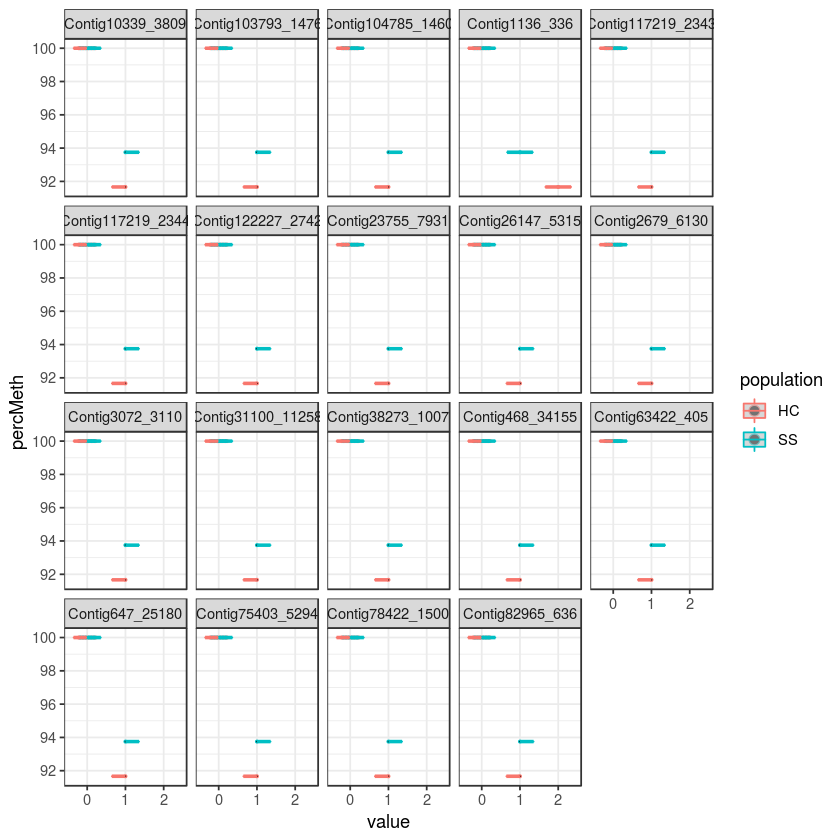

In [26]:
loci = "Contig63502_10530_10530"
m <- perc_meth %>% filter(site==loci)
s <- meS$trans$eqtls[which(meS$trans$eqtls$gene == loci & meS$trans$eqtls$FDR < 0.05),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw()

In [2]:
# how many trans-meth in Cpg-snp
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../analyses/2bRAD/MethGen/cpgsnps.bed  >  ../analyses/2bRAD/mQTL/trans-meth-cpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/trans-meth-cpgsnp.bed")


0 ../analyses/2bRAD/mQTL/trans-meth-cpgsnp.bed


In [7]:
# how many background meth in Cpg-snp
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/meth_allsites_mbd.bed -b ../analyses/2bRAD/MethGen/cpgsnps.bed  >  ../analyses/2bRAD/mQTL/background-meth-cpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/background-meth-cpgsnp.bed")


43 ../analyses/2bRAD/mQTL/background-meth-cpgsnp.bed


In [9]:
# how many trans-meth in nonCpg-snp
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../analyses/2bRAD/Inputs/non-cpgsnps.bed   >  ../analyses/2bRAD/mQTL/trans-meth-noncpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/trans-meth-noncpgsnp.bed")


1 ../analyses/2bRAD/mQTL/trans-meth-noncpgsnp.bed


In [51]:
# how many background meth in non Cpg-snp
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/meth_allsites_mbd.bed -b ../analyses/2bRAD/Inputs/non-cpgsnps.bed  >  ../analyses/2bRAD/mQTL/background-meth-noncpgsnp.bed")
js("wc -l ../analyses/2bRAD/mQTL/background-meth-noncpgsnp.bed")


164 ../analyses/2bRAD/mQTL/background-meth-noncpgsnp.bed


### 0 trans-meth sites are near cpg-snps, cpg snps enriched in cis meth relative to trans meth

In [10]:
Input=("
mqtl    cpgsnp noncpgsnp
transm   0      1
nontransm 43    163
")

In [11]:
Matriz = as.matrix(read.table(textConnection(Input),
                   header=TRUE, 
                   row.names=1))
fisher.test(Matriz,alternative = "two.sided")


	Fisher's Exact Test for Count Data

data:  Matriz
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
   0.0000 148.4016
sample estimates:
odds ratio 
         0 


### meth sites near cis-mqtls enriched for cpg-snps over meth sites near trans-mqtls

In [12]:
Input=("
cpgsnp  cis  trans 
mqtl   6      0
nonmqtl  16    43
")

In [13]:
Matriz = as.matrix(read.table(textConnection(Input),
                   header=TRUE, 
                   row.names=1))
fisher.test(Matriz,alternative = "two.sided")


	Fisher's Exact Test for Count Data

data:  Matriz
p-value = 0.0009033
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 2.727558      Inf
sample estimates:
odds ratio 
       Inf 


### cis vs trans near a CpG-SNP 

In [6]:
Input=("
loc    cis trans
mqtl   6     0
nomqtl 16    43
")
Matriz = as.matrix(read.table(textConnection(Input),
                   header=TRUE, 
                   row.names=1))
fisher.test(Matriz,alternative = "two.sided")


	Fisher's Exact Test for Count Data

data:  Matriz
p-value = 0.0009033
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 2.727558      Inf
sample estimates:
odds ratio 
       Inf 


In [7]:
Matriz

,cis,trans
mqtl,6,0
nomqtl,16,43


### tested meth sites with a cpg-snp

In [11]:
#shouls all add up to 33738
cis.cpg = 22
trans.cpg = 43

Input=("
loc    cis trans
cpg    22     43
npcpg  1487    33695
")

Matriz = as.matrix(read.table(textConnection(Input),
                   header=TRUE, 
                   row.names=1))
fisher.test(Matriz,alternative = "two.sided")


	Fisher's Exact Test for Count Data

data:  Matriz
p-value = 1.4e-14
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  6.585298 19.863602
sample estimates:
odds ratio 
  11.58959 


In [12]:
Matriz

,cis,trans
cpg,22,43
npcpg,1487,33695


### unique meth sites with a mQTL

In [22]:
Input=("
loc    mQTL nomQTL
cis 121     1388
trans 362    31988
")
Matriz = as.matrix(read.table(textConnection(Input),
                   header=TRUE, 
                   row.names=1))
fisher.test(Matriz,alternative = "two.sided")


	Fisher's Exact Test for Count Data

data:  Matriz
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 6.172463 9.558390
sample estimates:
odds ratio 
  7.703465 


In [23]:
Matriz

,mQTL,nomQTL
cis,121,1388
trans,362,31988


## methQTLs and DML/DMG overlap 
* What percent of local methQTLs near a DML vs non local mQTLS ? : 14.9% v 10.5%, not significant

In [13]:
# how many DMLs near a local methQTL meth site
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_cis.bed -b ../analyses/DMLs/dml25_forIGV.bed > ../analyses/2bRAD/mQTL/cis-meth-DMLs-350bp.bed")
js("wc -l ../analyses/2bRAD/mQTL/cis-meth-DMLs-350bp.bed")


18 ../analyses/2bRAD/mQTL/cis-meth-DMLs-350bp.bed


In [14]:
# how many background cis meth 
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/snpBmethA_50kb.txt -b ../analyses/DMLs/dml25_forIGV.bed  >  ../analyses/2bRAD/mQTL/background-cismeth-DMLs-350bp.bed")
js("wc -l ../analyses/2bRAD/mQTL/background-cismeth-DMLs-350bp.bed")


139 ../analyses/2bRAD/mQTL/background-cismeth-DMLs-350bp.bed


In [16]:
139-18
(1509-362)-121

[1] 121

[1] 1026

In [17]:
Input=("
loc    mQTL nonmQTL
DML    18    121
nonDML  103   1026
")
Matriz = as.matrix(read.table(textConnection(Input),
                   header=TRUE, 
                   row.names=1))
fisher.test(Matriz,alternative = "two.sided")


	Fisher's Exact Test for Count Data

data:  Matriz
p-value = 0.1669
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8155921 2.5645514
sample estimates:
odds ratio 
  1.481304 


In [18]:
Matriz

,mQTL,nonmQTL
DML,18,121
nonDML,103,1026


In [19]:
js("cat ../analyses/2bRAD/mQTL/cis-meth-DMLs-350bp.bed")

Contig173	13455	13455
Contig31124	5961	5961
Contig173	13500	13500
Contig18086	7978	7978
Contig7105	298	298
Contig24692	5520	5520
Contig173	13682	13682
Contig52148	10814	10814
Contig18086	7792	7792
Contig168159	621	621
Contig82938	2352	2352
Contig173	13651	13651
Contig168159	846	846
Contig168159	859	859
Contig7105	701	701
Contig39605	22761	22761
Contig47538	12037	12037
Contig18086	7781	7781


In [21]:
js("bedtools intersect -a ../analyses/2bRAD/mQTL/cis-meth-DMLs-350bp.bed -wb -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff")


Contig31124	5961	5961	Contig31124	maker	gene	1	8078	.	+	.	ID=OLUR_00022522;Name=OLUR_00022522;Alias=maker-Contig31124-snap-gene-0.2;Note=Similar to Chdh: Choline dehydrogenase%2C mitochondrial (Mus musculus OX%3D10090);Dbxref=CDD:cd01427,Gene3D:G3DSA:3.30.560.10,Gene3D:G3DSA:3.40.50.1000,Gene3D:G3DSA:3.50.50.60,InterPro:IPR000172,InterPro:IPR006439,InterPro:IPR007867,InterPro:IPR023214,InterPro:IPR036188,InterPro:IPR036412,MobiDBLite:mobidb-lite,Pfam:PF00732,Pfam:PF05199,Pfam:PF13419,ProSitePatterns:PS00623,ProSitePatterns:PS00624,SUPERFAMILY:SSF51905,SUPERFAMILY:SSF54373,SUPERFAMILY:SSF56784,TIGRFAM:TIGR01549;Ontology_term=GO:0016614,GO:0016787,GO:0050660,GO:0055114;SPID=Q8BJ64;
Contig18086	7978	7978	Contig18086	maker	gene	1	10669	.	+	.	ID=OLUR_00020258;Name=OLUR_00020258;Alias=maker-Contig18086-snap-gene-0.2;Note=Similar to PRICKLE2: Prickle-like protein 2 (Homo sapiens OX%3D9606);Dbxref=CDD:cd09340,CDD:cd09418,CDD:cd09420,CDD:cd09827,Gene3D:G3DSA:2.10.110.10,InterPro:IPR001781,Inter

In [38]:
library(dplyr)
library(ggplot2)

In [28]:
geno <- read.table("../analyses/2bRAD/mQTL/MBD_HCSS_Afilt32m70_maf05_m2pop_format.tab",header = T)

In [32]:
geno %>% mutate_if(is.factor, as.character) -> geno

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Warning message:
“Removed 1 rows containing non-finite values (stat_bindot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


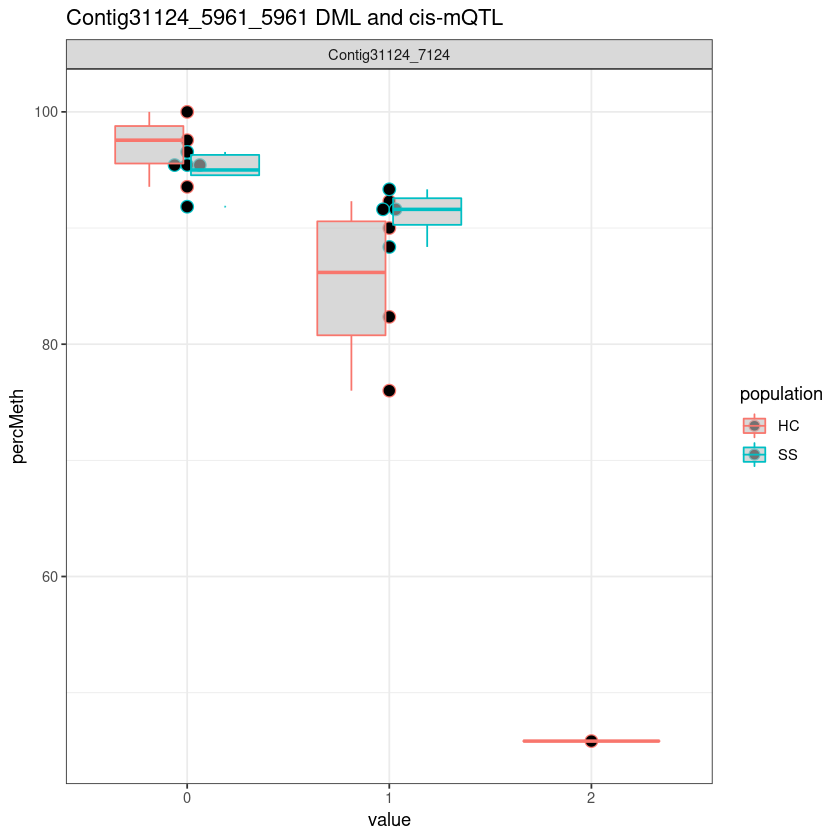

In [39]:
loci = "Contig31124_5961_5961"
m <- perc_meth %>% filter(site==loci)
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == loci),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle(paste0(loci," DML and cis-mQTL"))

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



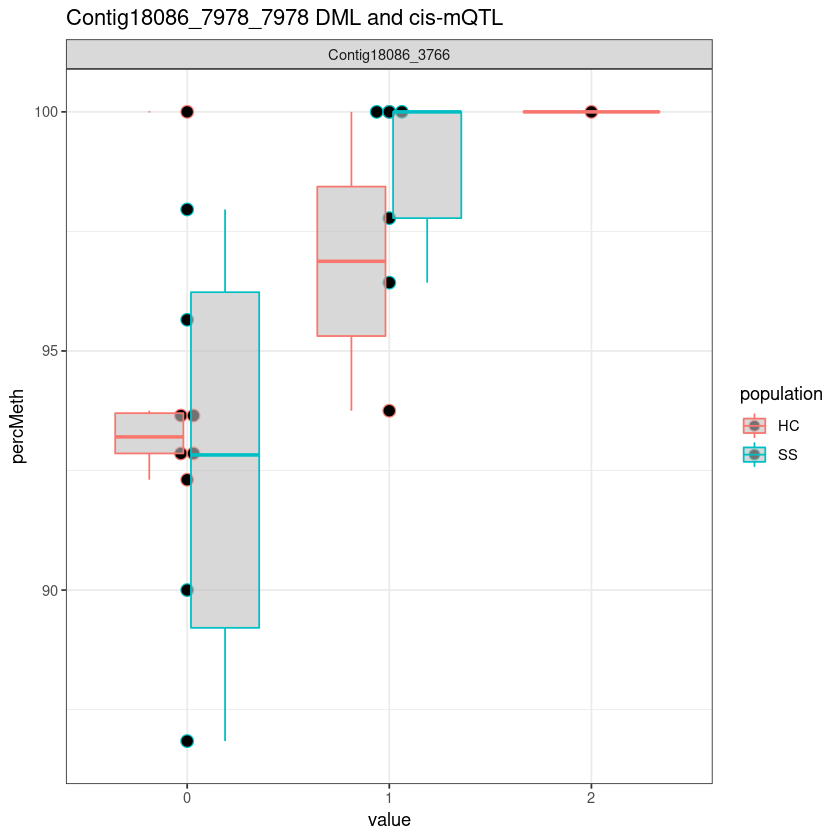

In [41]:
loci = "Contig18086_7978_7978"
m <- perc_meth %>% filter(site==loci)
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == loci),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle(paste0(loci," DML and cis-mQTL"))

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Warning message:
“Removed 3 rows containing non-finite values (stat_bindot).”
Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”


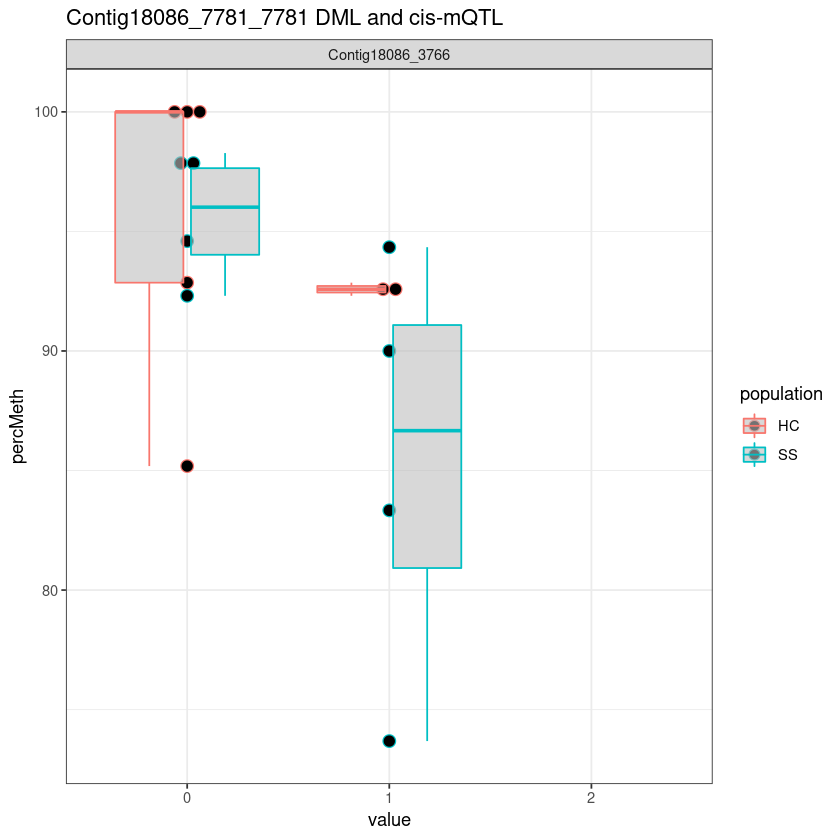

In [43]:
loci = "Contig18086_7781_7781"
m <- perc_meth %>% filter(site==loci)
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == loci),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle(paste0(loci," DML and cis-mQTL"))

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Warning message:
“Removed 3 rows containing non-finite values (stat_bindot).”
Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”


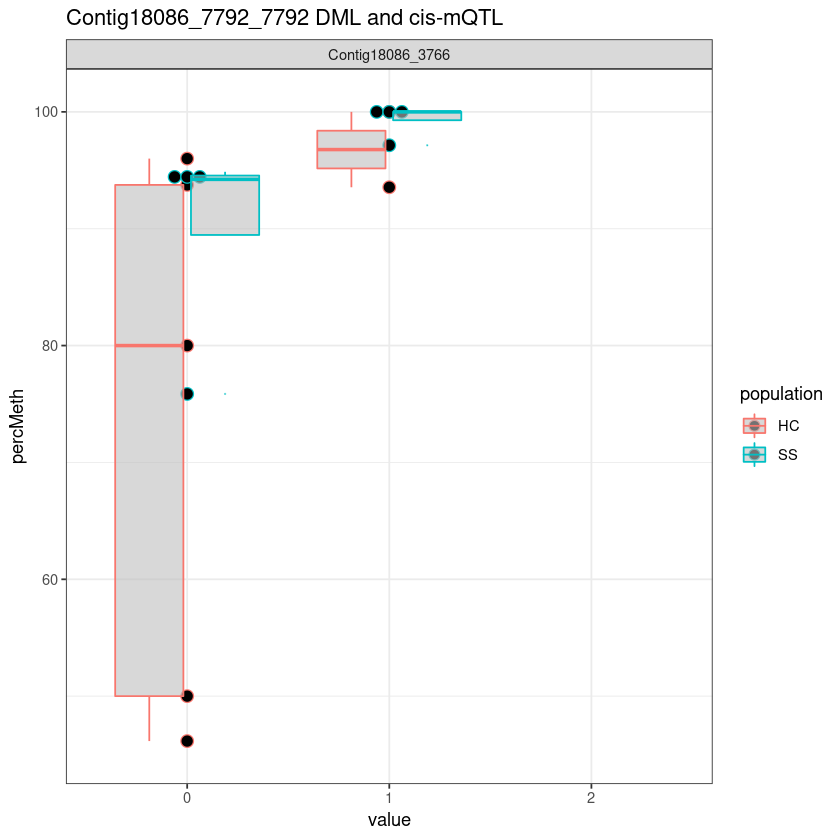

In [42]:
loci = "Contig18086_7792_7792"
m <- perc_meth %>% filter(site==loci)
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == loci),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle(paste0(loci," DML and cis-mQTL"))

In [ ]:
Contig173	13455	13455
Contig31124	5961	5961
Contig173	13500	13500
Contig168159	621	621
Contig82938	2352	2352
Contig39605	22761	22761

ERROR while rich displaying an object: Error: Faceting variables must have at least one value

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste

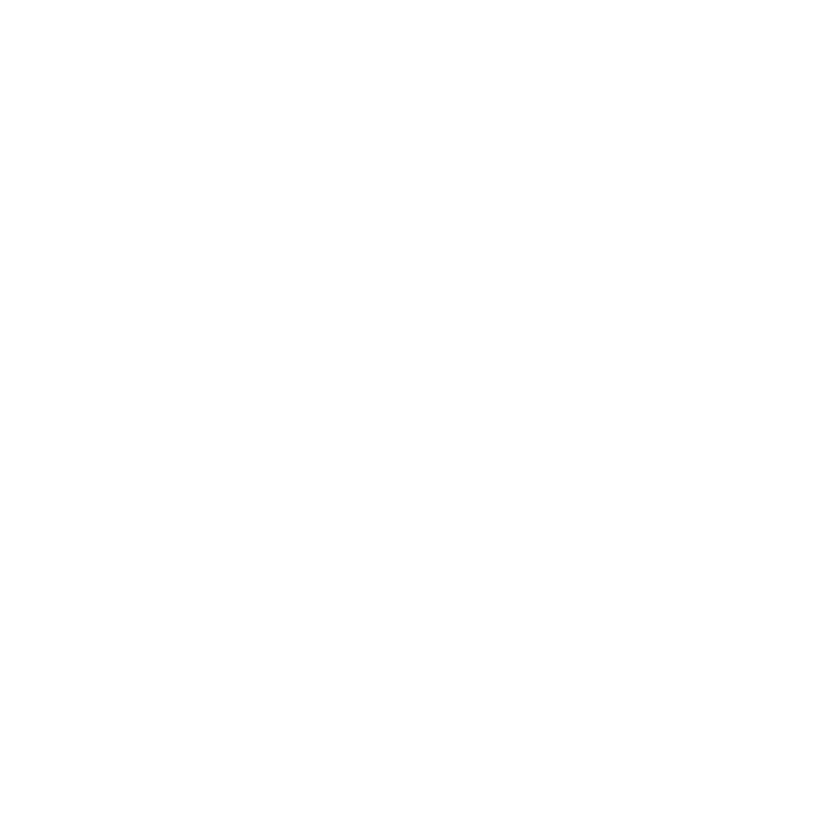

In [40]:
loci = "Contig173_13455_13455"
m <- perc_meth %>% filter(site==loci)
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == loci),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle(paste0(loci," DML and cis-mQTL"))

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 1 rows containing non-finite values (stat_bindot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


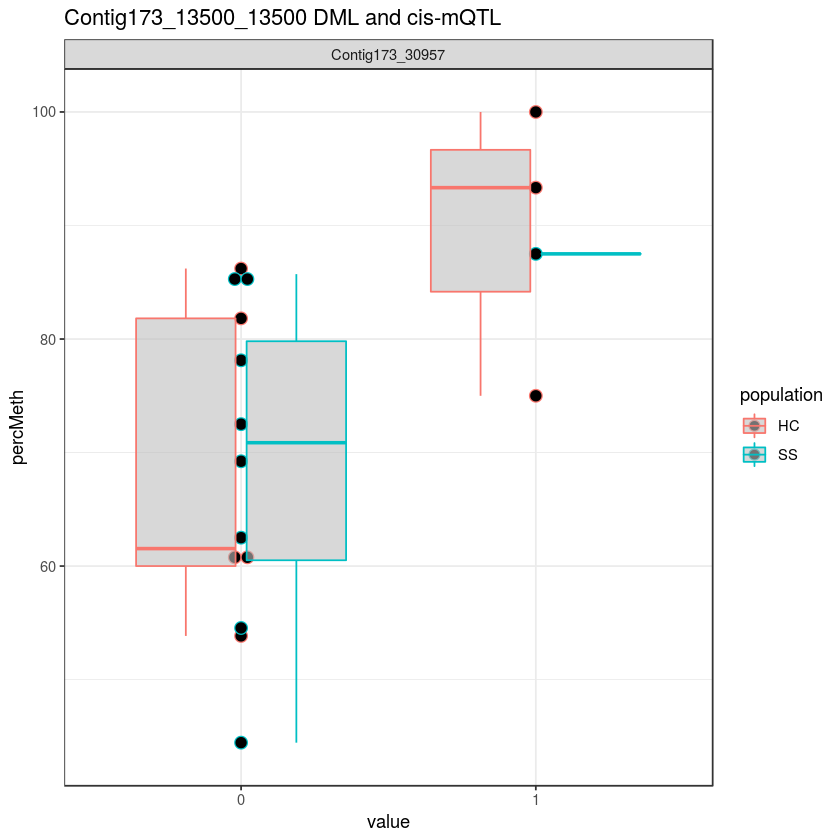

In [53]:
loci = "Contig173_13500_13500"
m <- perc_meth %>% filter(site==loci)
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == loci),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle(paste0(loci," DML and cis-mQTL"))

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 4 rows containing non-finite values (stat_bindot).”
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”


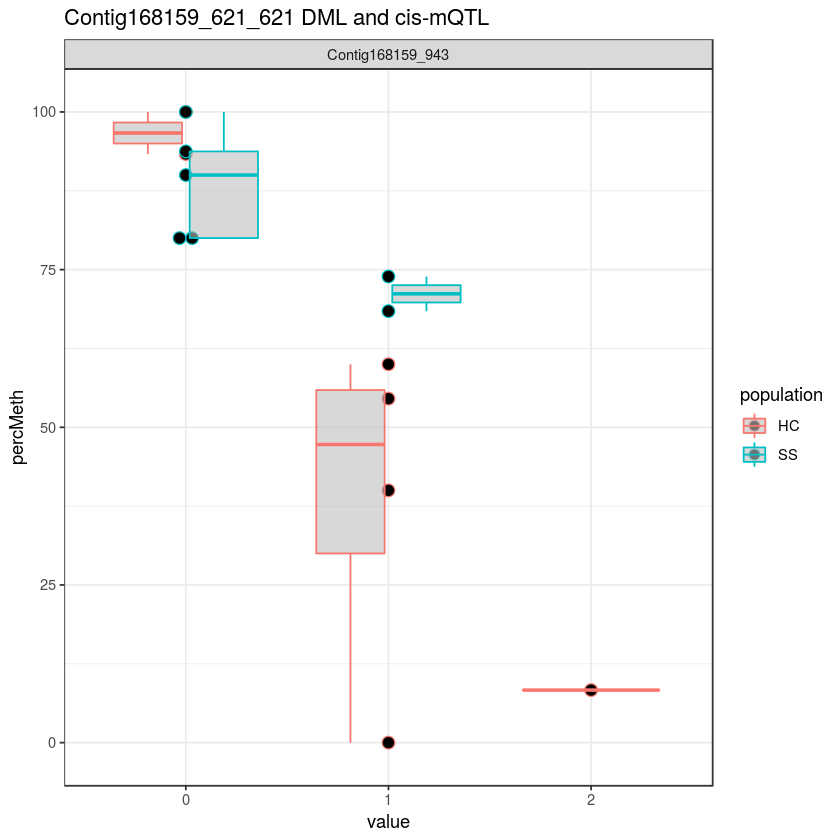

In [54]:
loci = "Contig168159_621_621"
m <- perc_meth %>% filter(site==loci)
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == loci),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle(paste0(loci," DML and cis-mQTL"))

* What percent of DMLs overall are associated with a distant mqtl vs non overall dmls

In [22]:
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/meth_allsites_mbd.bed -b ../analyses/DMLs/dml25_forIGV.bed >  ../analyses/2bRAD/mQTL/background-meth-DML-350bp.bed")
js("wc -l ../analyses/2bRAD/mQTL/background-meth-DML-350bp.bed")


2112 ../analyses/2bRAD/mQTL/background-meth-DML-350bp.bed


In [23]:
# how many DMLs near a distant methQTL meth site
js("bedtools window -w 350 -u -a ../analyses/2bRAD/mQTL/meth_mbd_maf05_sites_transF05.bed -b ../analyses/DMLs/dml25_forIGV.bed > ../analyses/2bRAD/mQTL/trans-meth-DMLs-350bp.bed")
js("wc -l ../analyses/2bRAD/mQTL/trans-meth-DMLs-350bp.bed")


12 ../analyses/2bRAD/mQTL/trans-meth-DMLs-350bp.bed


### are proportion of local mQTL with DML higher than distant mQTL with DML? yes (14.9% vs 3.3%)

In [14]:
Input=("
DML    local distant
mQ     18      12
nmQ  139   2112
")

In [15]:

Matriz = as.matrix(read.table(textConnection(Input),
                   header=TRUE, 
                   row.names=1))
fisher.test(Matriz,alternative = "two.sided")


	Fisher's Exact Test for Count Data

data:  Matriz
p-value = 1.965e-14
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 10.11296 52.78938
sample estimates:
odds ratio 
  22.69976 


In [26]:
js("cat ../analyses/2bRAD/mQTL/trans-meth-DMLs-350bp.bed")

Contig32656	11956	11956
Contig48322	769	769
Contig34596	13436	13436
Contig152	9299	9299
Contig158671	1771	1771
Contig31171	23860	23860
Contig128000	3308	3308
Contig9165	801	801
Contig857	14584	14584
Contig62898	1215	1215
Contig47816	2372	2372
Contig17966	14589	14589


In [27]:
js("bedtools intersect -a ../analyses/2bRAD/mQTL/trans-meth-DMLs-350bp.bed -wb -b ../genome-features/Olurida_v081-20190709.gene.2kbslop.gff")


Contig32656	11956	11956	Contig32656	maker	gene	3107	13766	.	-	.	ID=OLUR_00016774;Name=OLUR_00016774;Alias=maker-Contig32656-snap-gene-0.3;Note=Protein of unknown function;Dbxref=MobiDBLite:mobidb-lite;
Contig34596	13436	13436	Contig34596	maker	gene	10571	27315	.	+	.	ID=OLUR_00006369;Name=OLUR_00006369;Alias=maker-Contig34596-snap-gene-0.4;Note=Protein of unknown function;Dbxref=MobiDBLite:mobidb-lite;
Contig152	9299	9299	Contig152	maker	gene	4965	37832	.	-	.	ID=OLUR_00002517;Name=OLUR_00002517;Alias=snap_masked-Contig152-processed-gene-0.3;Note=Similar to ahctf1: Protein ELYS (Xenopus laevis OX%3D8355);Dbxref=Coils:Coil,InterPro:IPR025151,InterPro:IPR032040,MobiDBLite:mobidb-lite,Pfam:PF13934,Pfam:PF16687;SPID=Q5U249;
Contig31171	23860	23860	Contig31171	maker	gene	1	40835	.	-	.	ID=OLUR_00000353;Name=OLUR_00000353;Alias=maker-Contig31171-snap-gene-0.6;Note=Similar to Crocc: Rootletin (Mus musculus OX%3D10090);Dbxref=Coils:Coil,Gene3D:G3DSA:1.20.5.340,MobiDBLite:mobidb-lite,Pfam:PF15035,